In [237]:
#import modules
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import cv2
import scipy
from scipy.signal import convolve2d
import statistics
from scipy.signal import convolve2d
import time
from skimage.data import page
from skimage.filters import (threshold_niblack)
from skimage import data
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import disk
import skimage.measure

# Functions

In [238]:
#function to get value for Fast Noise Estimation
# Ref: https://stackoverflow.com/questions/2440504/noise-estimation-noise-measurement-in-image
def estimate_noise(I):
  H, W = I.shape
  Fil = [[1, -2, 1],
       [-2, 4, -2],
       [1, -2, 1]]
  sigma = np.sum(np.sum(np.absolute(convolve2d(I, Fil))))
  sigma = sigma * math.sqrt(0.5 * math.pi) / (6 * (W-2) * (H-2))
  return sigma

In [239]:
#Function to display 2 images and noise results
def compare_imgs(old_img, new_img):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(old_img, cmap="gray");
    ax[1].imshow(new_img, cmap="gray");

    noise_old = estimate_noise(old_img)
    noise_new = estimate_noise(new_img)

    print("Noise in Left Image is:", noise_old)
    print("Noise in Right Image is:", noise_new)

In [240]:
def display_img(img):
    plt.imshow(img, cmap="gray");

In [241]:
#Define Centre-Weighted Median Filter (Taken from my work in A1 (Miriam))

def cen_median(img):
    x = img.shape[0]
    y = img.shape[1]
    weights = np.array([[0.03, 0.03, 0.03, 0.03, 0.03],
                    [0.03, 0.05, 0.05, 0.05, 0.05],
                    [0.03, 0.05, 0.12, 0.05, 0.05],
                    [0.03, 0.05, 0.05, 0.05, 0.05],
                    [0.03, 0.03, 0.03, 0.03, 0.03]])
    #create space domain filter 2D
    new_img = np.zeros([x,y]);
    for i in range (3, x-3): #range defined to exlude outermost pixels
        for j in range (3, y-3):
            win = np.zeros([5,5])
            win[2,2] = img[i,j] #define centre pixel
            for wx in range(5): #define window
                for wy in range(5):
                    xdiff = wx - 2
                    ydiff = wy - 2
                    win[wx,wy] = img[i + xdiff, j + ydiff]
            #assign weights
            win_long = win.reshape(25,1)
            weight_long = weights.reshape(25,1)
            win_weights = np.concatenate((win_long, weight_long), axis=1) 
            win_weights_pd = pd.DataFrame(win_weights, columns=['Values', 'Weight'])
            #sort by values
            sorted_values = win_weights_pd.sort_values(by =['Values'])
            sorted_values = sorted_values.to_numpy()
        #Add weights until 0.5 is reached
            sum = 0
            for d in range(24):
                sorted_values
                sum = sum + sorted_values[d,1]
                if sum > 0.5:
                    new_img[i,j] = sorted_values[d,0] #assigns centre weighted median
                    break
    return new_img

In [242]:
#Simple 5X5 mean filter
def mean_5(img):
    kernel = np.ones((5,5),np.float32)/25
    new_img = cv2.filter2D(img,-1,kernel)
    return new_img
#Simple 11X11 mean filter
def mean_11(img):
    kernel = np.ones((11,11),np.float32)/121
    new_img = cv2.filter2D(img,-1,kernel)
    return new_img

In [299]:
def thresholding(img, thresh_value, display):
    thresholded_liver = np.zeros((364,597,3))
    thresholded_liver_image = np.copy(img)
    for i in range(363):
        for j in range(596):
            if img[i,j] < thresh_value and img[i,j] > 1:
                thresholded_liver[i,j,1] = 1
                thresholded_liver_image[i,j] = 255
            else:
                thresholded_liver[i,j,1] = 0
    if display == 1:
        #Display Mask
        mask = thresholded_liver
        masked = np.ma.masked_where(mask == 0, mask)

        import matplotlib.pyplot as plt
        plt.figure()
        plt.imshow(img, 'gray', interpolation='none')
        plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
        plt.show()

    return thresholded_liver_image

In [357]:
#same as thresholding function but it takes 2 values for upper and lower bounds
def thresholding_2(img, thresh_value_low, thresh_value_high, display):
    thresholded_liver = np.zeros((364,597,3))
    thresholded_liver_image = np.copy(img)
    for i in range(363):
        for j in range(596):
            if img[i,j] < thresh_value_high and img[i,j] > thresh_value_low and img[i,j] > 1:
                thresholded_liver[i,j,1] = 1
                thresholded_liver_image[i,j] = 255
            else:
                thresholded_liver[i,j,1] = 0
    if display == 1:
        #Display Mask
        mask = thresholded_liver
        masked = np.ma.masked_where(mask == 0, mask)

        import matplotlib.pyplot as plt
        plt.figure()
        plt.imshow(img, 'gray', interpolation='none')
        plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
        plt.show()

    return thresholded_liver_image

In [419]:
#function to define windows of liver and non-liver tissue
def find_liver_windows(liver_only_a, nonliver_only_a, window_size):
    liver_only = np.copy(liver_only_a)
    nonliver_only = np.copy(nonliver_only_a)
    liver_true_windows = []
    liver_false_windows = []
    for i in range(int(np.round(597/window_size))):
        column_end = ((i+1)*window_size)
        column_start = column_end-window_size
        for j in range(int(np.round(364/window_size))):
            row_end = ((j+1)*window_size)
            row_start = row_end-window_size
            window_defined = np.array([row_start, row_end, column_start, column_end])
            #define liver windows
            window_liver_only = liver_only[row_start:row_end,column_start:column_end]
            black_pixels = np.where(window_liver_only == 0)
            if len(black_pixels[1]) < 20:
                liver_true_windows.append(window_defined)
            #define nonliver windows
            window_nonliver_only = nonliver_only[row_start:row_end,column_start:column_end]
            black_pixels_2 = np.where(window_nonliver_only == 0)
            if len(black_pixels_2[1]) < 20:
                liver_false_windows.append(window_defined)

    for i in range(len(liver_true_windows)):
        [row_start, row_end, column_start, column_end] = liver_true_windows[i]
        liver_only[row_start:row_end,column_start:column_end] = 255

    for i in range(len(liver_false_windows)):
        [row_start, row_end, column_start, column_end] = liver_false_windows[i]
        nonliver_only[row_start:row_end,column_start:column_end] = 255

    #plotting
    matplotlib.rcParams['font.size'] = 10
    plt.figure(figsize=(12, 7))
    plt.subplot(2, 2, 1)
    plt.imshow(liver_only_a, cmap=plt.cm.gray)
    plt.title('Liver')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.title('Liver Segments')
    plt.imshow(liver_only, cmap=plt.cm.gray)
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(nonliver_only_a, cmap=plt.cm.gray)
    plt.title('Non-Liver')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(nonliver_only, cmap=plt.cm.gray)
    plt.title('Non-Liver Segments')
    plt.axis('off')

    plt.show()
    
    return liver_true_windows, liver_false_windows

In [245]:
#create mask for liver only (ground truth)
def get_truth(segment, value):
    liver_mask = np.zeros((364,597))
    for i in range(363):
        for j in range(596):
            if segment[i-1,j] == value and segment[i+1,j] == value and segment[i,j+1] == value:
                liver_mask[i,j] = 1
            elif segment[i,j-1] == value and segment[i,j+1] == value and segment[i+1,j] == value:
                liver_mask[i,j] = 1
            else:
                liver_mask[i,j] = 0
    return liver_mask

In [391]:
#plot 10 images
def plot_10(image1, liver_mask_1, image2, liver_mask_2, image3, liver_mask_3, image4, liver_mask_4, image5, liver_mask_5, image6, liver_mask_6, image7, liver_mask_7, image8, liver_mask_8, image9, liver_mask_9, image10, liver_mask_10, mask):

    i1_acc, i1_liver_acc = get_accuracy(image1, liver_mask_1, mask, 0)
    i1_acc = i1_acc*100
    i1_liver_acc = i1_liver_acc*100
    i2_acc, i2_liver_acc = get_accuracy(image2, liver_mask_2, mask, 0)
    i2_acc = i2_acc*100
    i2_liver_acc = i2_liver_acc*100
    i3_acc, i3_liver_acc = get_accuracy(image3, liver_mask_3, mask, 0)
    i3_acc = i3_acc*100
    i3_liver_acc = i3_liver_acc*100
    i4_acc, i4_liver_acc = get_accuracy(image4, liver_mask_4, mask, 0)
    i4_acc = i4_acc*100
    i4_liver_acc = i4_liver_acc*100
    i5_acc, i5_liver_acc = get_accuracy(image5, liver_mask_5, mask, 0)
    i5_acc = i5_acc*100
    i5_liver_acc = i5_liver_acc*100
    i6_acc, i6_liver_acc = get_accuracy(image6, liver_mask_6, mask, 0)
    i6_acc = i6_acc*100
    i6_liver_acc = i6_liver_acc*100
    i7_acc, i7_liver_acc = get_accuracy(image7, liver_mask_7, mask, 0)
    i7_acc = i7_acc*100
    i7_liver_acc = i7_liver_acc*100
    i8_acc, i8_liver_acc = get_accuracy(image8, liver_mask_8, mask, 0)
    i8_acc = i8_acc*100
    i8_liver_acc = i8_liver_acc*100
    i9_acc, i9_liver_acc = get_accuracy(image9, liver_mask_9, mask, 0)
    i9_acc = i9_acc*100
    i9_liver_acc = i9_liver_acc*100
    i10_acc, i10_liver_acc = get_accuracy(image10, liver_mask_10, mask, 0)
    i10_acc = i10_acc*100
    i10_liver_acc = i10_liver_acc*100
    
    #plotting
    matplotlib.rcParams['font.size'] = 9
    plt.figure(figsize=(13, 13))
    plt.subplot(4, 3, 1)
    plt.imshow(image1, cmap="gray")
    plt.title('Test Image 1 (Healthy) with accuracy: %d, %d' %(i1_acc, i1_liver_acc))
    plt.axis('off')

    plt.subplot(4, 3, 2)
    plt.title('Test Image 2 (Healthy) with accuracy: %d, %d' %(i2_acc, i2_liver_acc))
    plt.imshow(image2, cmap="gray")
    plt.axis('off')

    plt.subplot(4, 3, 3)
    plt.imshow(image3, cmap="gray")
    plt.title('Test Image 3 (Healthy) with accuracy: %d, %d' %(i3_acc, i3_liver_acc))
    plt.axis('off')

    plt.subplot(4, 3, 4)
    plt.imshow(image4, cmap="gray")
    plt.title('Test Image 4 (Fatty) with accuracy: %d, %d' %(i4_acc, i4_liver_acc))
    plt.axis('off')

    plt.subplot(4, 3, 5)
    plt.imshow(image5, cmap="gray")
    plt.title('Test Image 5 (Fatty) with accuracy: %d, %d' %(i5_acc, i5_liver_acc))
    plt.axis('off')

    plt.subplot(4, 3, 6)
    plt.imshow(image6, cmap="gray")
    plt.title('Test Image 6 (Fatty) with accuracy: %d, %d' %(i6_acc, i6_liver_acc))
    plt.axis('off')

    plt.subplot(4, 3, 7)
    plt.imshow(image7, cmap="gray")
    plt.title('Test Image 7 (Fatty) with accuracy: %d, %d' %(i7_acc, i7_liver_acc))
    plt.axis('off')

    plt.subplot(4, 3, 8)
    plt.imshow(image8, cmap="gray")
    plt.title('Test Image 8 (Fatty) with accuracy: %d, %d' %(i8_acc, i8_liver_acc))
    plt.axis('off')

    plt.subplot(4, 3, 9)
    plt.imshow(image9, cmap="gray")
    plt.title('Test Image 9 (Fatty) with accuracy: %d, %d' %(i9_acc, i9_liver_acc))
    plt.axis('off')

    plt.subplot(4, 3, 10)
    plt.imshow(image10, cmap="gray")
    plt.title('Test Image 10 (Fatty) with accuracy: %d, %d' %(i10_acc, i10_liver_acc))
    plt.axis('off')

    plt.show()
    
    mean_acc = np.mean([i1_acc, i2_acc, i3_acc, i4_acc, i5_acc, i6_acc, i7_acc, i8_acc, i9_acc, i10_acc])
    mean_liver_acc = np.mean([i1_liver_acc, i2_liver_acc, i3_liver_acc, i4_liver_acc, i5_liver_acc, i6_liver_acc, i7_liver_acc, i8_liver_acc, i9_liver_acc, i10_liver_acc])
    
    print('Mean Classification Accuracy is:', mean_acc, '%')
    print('Mean Classification Accuracy for liver only is:', mean_liver_acc, '%')

In [305]:
#get accuracy for correctly classified pixels
def get_accuracy(thresholded_image, liver_mask, mask, display):
    correct = 0
    total = 0
    #count correctly classified pixels
    for i in range(364):
        for j in range(597):
            if mask[i,j] == 1:
                total = total + 1
                if thresholded_image[i,j] == 255 and liver_mask[i,j] == 1:
                    correct = correct + 1
                elif thresholded_image[i,j] != 255 and liver_mask[i,j] != 1:
                    correct = correct + 1
    
    #count correctly classified liver only pixels
    correct_liver = 0
    liver_total = 0
    for i in range(364):
        for j in range(597):
            if liver_mask[i,j] == 1:
                liver_total = liver_total + 1
                if thresholded_image[i,j] == 255 and liver_mask[i,j] == 1:
                    correct_liver = correct_liver + 1

    #calculate accuracy
    accuracy_liver = correct_liver/liver_total
    accuracy = correct/total
    if display == 1:
        print('Accuracy for image is:', accuracy)
        print('Accuracy for liver is:', accuracy_liver)

    return accuracy, accuracy_liver

In [593]:
#function that combines liver defined by thresholding WITH non-liver defined by entropy

def entropy_thresh_combo(image_mean_filtered, threshold_result, full_liver_windows):

    i1 = threshold_result
    og_img = np.copy(image_mean_filtered)
    entropy_img = np.copy(image_mean_filtered)
    combo_img = np.copy(image_mean_filtered)
    full_liver_windows = full_liver_windows #boxes

    #define entropy threshold (for non-liver)
    entropy_thresh = 9.14 #(keeping this at 6 from image 1)
    entropy_liver_x = []

    for i in range(len(full_liver_windows)):
        [row_start, row_end, column_start, column_end] = full_liver_windows[i]
        entropy_liver_x.append(skimage.measure.shannon_entropy(entropy_img[row_start:row_end,column_start:column_end]))

    for i in range(len(full_liver_windows)):
        if entropy_liver_x[i] > entropy_thresh:
            [row_start, row_end, column_start, column_end] = full_liver_windows[i]
            entropy_img[row_start:row_end,column_start:column_end] = 255

    #combine
    for i in range(364):
        for j in range(597):
            if i1[i,j] == 255 and entropy_img[i,j] != 255:
                combo_img[i,j] = 255

#     for i in range(364): #if entropy thresholding is detected lower than 150, eliminate all below(150 is defenitely below skin)
#         for j in range(597):            
#             if entropy_img[i,j] == 255 and i>150:
#                     for r in range(i,364):
#                         combo_img[r,j] = og_img[r,j]
                        
    for i in range(364): #if entropy thresholding is detected lower than 150, eliminate all to the left and all below (150 is defenitely below skin)
        for j in range(597):            
            if entropy_img[i,j] == 255 and i>150:                       
                    for c in range(0,j):
                        combo_img[i,c] = og_img[i,c]
                        for r in range(i, 364):
                            combo_img[r,c] = og_img[r,c]
                        
    return combo_img

In [621]:
#function that combines liver defined by thresholding WITH non-liver defined by STD

def std_thresh_combo(image, threshold_result, full_liver_windows):

    i1 = threshold_result
    og_img = np.copy(image)
    std_img = np.copy(image)
    combo_img = np.copy(image)
    full_liver_windows = full_liver_windows #boxes

    #define entropy threshold (for non-liver)
    std_thresh = 19.5
    std_liver_1 = []

    for i in range(len(full_liver_windows)):
        [row_start, row_end, column_start, column_end] = full_liver_windows[i]
        mean, std = cv2.meanStdDev(std_img[row_start:row_end,column_start:column_end])
        std_liver_1.append(int(std))
    
    for i in range(len(full_liver_windows)):
        if std_liver_1[i] > std_thresh:
            [row_start, row_end, column_start, column_end] = full_liver_windows[i]
            std_img[row_start:row_end,column_start:column_end] = 255

    #combine
    for i in range(364):
        for j in range(597):
            if i1[i,j] == 255 and std_img[i,j] != 255:
                combo_img[i,j] = 255

#     for i in range(364): #if entropy thresholding is detected lower than 150, eliminate all below(150 is defenitely below skin)
#         for j in range(597):            
#             if entropy_img[i,j] == 255 and i>150:
#                     for r in range(i,364):
#                         combo_img[r,j] = og_img[r,j]
                        
    for i in range(364): #if entropy thresholding is detected lower than 150, eliminate all to the left and all below (150 is defenitely below skin)
        for j in range(597):            
            if std_img[i,j] == 255 and i>150:                       
                    for c in range(0,j):
                        combo_img[i,c] = og_img[i,c]
                        for r in range(i, 364):
                            combo_img[r,c] = og_img[r,c]
                        
    return combo_img

In [635]:
#horizontal auto correlation feature
def autocoh(window, delay): #calculates autocorrelation feature in horizontal direction

    row = 25 
    col = 25
    windownew = np.reshape(window, (row*col)); 
    autocofeature = 0 

    #Delay of 1
    if delay == 1:
        for a in range(1, ((row*col) - 1)):
            autocofeature = autocofeature + windownew[a]*windownew[a+1]; 

    #Delay of 4
    if delay == 4:
        for a in range(1, ((row*col) - 4)): 
            autocofeature = autocofeature + windownew[a]*windownew[a+4];

    autocofeature = np.sqrt(autocofeature);

    return autocofeature

# Set-up

In [306]:
#load in test images (note that images 1-3 are healthy livers, but images 4-10 are fatty)
test_img_1_h = cv2.imread('liver_id_8_image_1.png')
test_img_1_segment = cv2.imread('liver_id_8_image_1_segment.png')
test_img_2_h = cv2.imread('liver_id_1_image_10.png')
test_img_2_segment = cv2.imread('liver_id_1_image_10_segment.png')
test_img_3_h = cv2.imread('liver_id_11_image_5.png')
test_img_3_segment = cv2.imread('liver_id_11_image_5_segment.png')
test_img_4_h = cv2.imread('liver_id_23_image_8.png')
test_img_4_segment = cv2.imread('liver_id_23_image_8_segment.png')
test_img_5_h = cv2.imread('liver_id_25_image_6.png')
test_img_5_segment = cv2.imread('liver_id_25_image_6_segment.png')
test_img_6_h = cv2.imread('liver_id_32_image_4.png')
test_img_6_segment = cv2.imread('liver_id_32_image_4_segment.png')
test_img_7_h = cv2.imread('liver_id_37_image_10.png')
test_img_7_segment = cv2.imread('liver_id_37_image_10_segment.png')
test_img_8_h = cv2.imread('liver_id_42_image_4.png')
test_img_8_segment = cv2.imread('liver_id_42_image_4_segment.png')
test_img_9_h = cv2.imread('liver_id_31_image_10.png')
test_img_9_segment = cv2.imread('liver_id_31_image_10_segment.png')
test_img_10_h = cv2.imread('liver_id_54_image_2.png')
test_img_10_segment = cv2.imread('liver_id_54_image_2_segment.png')

image_mask = cv2.imread('liver_us_mask.png')

In [307]:
#convert all test images to grayscale & crop
test_img_1_h = np.dot(test_img_1_h, [0.2989, 0.5870, 0.1140])
test_img_1_h = test_img_1_h[0:364, 19:616]
test_img_2_h = np.dot(test_img_2_h, [0.2989, 0.5870, 0.1140])
test_img_2_h = test_img_2_h[0:364, 19:616]
test_img_3_h = np.dot(test_img_3_h, [0.2989, 0.5870, 0.1140])
test_img_3_h = test_img_3_h[0:364, 19:616]
test_img_4_h = np.dot(test_img_4_h, [0.2989, 0.5870, 0.1140])
test_img_4_h = test_img_4_h[0:364, 19:616]
test_img_5_h = np.dot(test_img_5_h, [0.2989, 0.5870, 0.1140])
test_img_5_h = test_img_5_h[0:364, 19:616]
test_img_6_h = np.dot(test_img_6_h, [0.2989, 0.5870, 0.1140])
test_img_6_h = test_img_6_h[0:364, 19:616]
test_img_7_h = np.dot(test_img_7_h, [0.2989, 0.5870, 0.1140])
test_img_7_h = test_img_7_h[0:364, 19:616]
test_img_8_h = np.dot(test_img_8_h, [0.2989, 0.5870, 0.1140])
test_img_8_h = test_img_8_h[0:364, 19:616]
test_img_9_h = np.dot(test_img_9_h, [0.2989, 0.5870, 0.1140])
test_img_9_h = test_img_9_h[0:364, 19:616]
test_img_10_h = np.dot(test_img_10_h, [0.2989, 0.5870, 0.1140])
test_img_10_h = test_img_10_h[0:364, 19:616]

test_img_1_segment = np.dot(test_img_1_segment, [0.2989, 0.5870, 0.1140])
test_img_1_segment = test_img_1_segment[0:364, 19:616]
test_img_2_segment = np.dot(test_img_2_segment, [0.2989, 0.5870, 0.1140])
test_img_2_segment = test_img_2_segment[0:364, 19:616]
test_img_3_segment = np.dot(test_img_3_segment, [0.2989, 0.5870, 0.1140])
test_img_3_segment = test_img_3_segment[0:364, 19:616]
test_img_4_segment = np.dot(test_img_4_segment, [0.2989, 0.5870, 0.1140])
test_img_4_segment = test_img_4_segment[0:364, 19:616]
test_img_5_segment = np.dot(test_img_5_segment, [0.2989, 0.5870, 0.1140])
test_img_5_segment = test_img_5_segment[0:364, 19:616]
test_img_6_segment = np.dot(test_img_6_segment, [0.2989, 0.5870, 0.1140])
test_img_6_segment = test_img_6_segment[0:364, 19:616]
test_img_7_segment = np.dot(test_img_7_segment, [0.2989, 0.5870, 0.1140])
test_img_7_segment = test_img_7_segment[0:364, 19:616]
test_img_8_segment = np.dot(test_img_8_segment, [0.2989, 0.5870, 0.1140])
test_img_8_segment = test_img_8_segment[0:364, 19:616]
test_img_9_segment = np.dot(test_img_9_segment, [0.2989, 0.5870, 0.1140])
test_img_9_segment = test_img_9_segment[0:364, 19:616]
test_img_10_segment = np.dot(test_img_10_segment, [0.2989, 0.5870, 0.1140])
test_img_10_segment = test_img_10_segment[0:364, 19:616]

image_mask = np.dot(image_mask, [0.2989, 0.5870, 0.1140])
image_mask = image_mask[0:364, 19:616]

81.9918

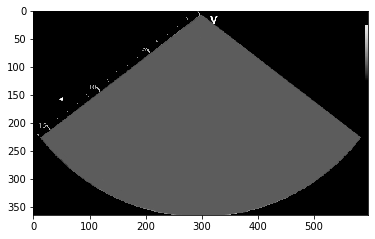

In [308]:
#display image mask
display_img(image_mask)
image_mask[320,202] #(find grayscale value of mask)

In [309]:
#Create mask for all ultrasound images
mask = np.zeros((364,597))
value = image_mask[320,202] #find value of mask
for i in range(363):
    for j in range(596):
        if image_mask[i,j] == value:
            mask[i,j] = 1
        elif image_mask[i,j-1] == value and image_mask[i,j+1] == value:
            mask[i,j] = 1
        elif image_mask[i-1,j] == value and image_mask[i+1,j] == value:
            mask[i,j] = 1
        else:
            mask[i,j] = 0

Noise in Left Image is: 2.6472408665975657
Noise in Right Image is: 2.396457649638636


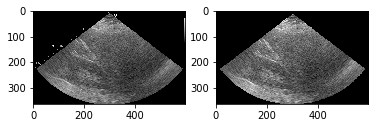

In [310]:
#mask
m_test_img_1_h = test_img_1_h * mask
m_test_img_2_h = test_img_2_h * mask
m_test_img_3_h = test_img_3_h * mask
m_test_img_4_h = test_img_4_h * mask
m_test_img_5_h = test_img_5_h * mask
m_test_img_6_h = test_img_6_h * mask
m_test_img_7_h = test_img_7_h * mask
m_test_img_8_h = test_img_8_h * mask
m_test_img_9_h = test_img_9_h * mask
m_test_img_10_h = test_img_10_h * mask

compare_imgs(test_img_10_h, m_test_img_10_h)

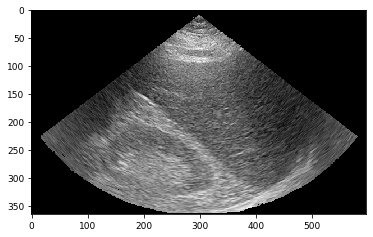

In [681]:
#Create masks for ground truth
#note: these masks were created manually by Miriam

value = image_mask[150,300] #find value of mask

liver_mask_1 = get_truth(test_img_1_segment, value)
liver_mask_2 = get_truth(test_img_2_segment, value)
liver_mask_3 = get_truth(test_img_3_segment, value)
liver_mask_4 = get_truth(test_img_4_segment, value)
liver_mask_5 = get_truth(test_img_5_segment, value)
liver_mask_6 = get_truth(test_img_6_segment, value)
liver_mask_7 = get_truth(test_img_7_segment, value)
liver_mask_8 = get_truth(test_img_8_segment, value)
liver_mask_9 = get_truth(test_img_9_segment, value)
liver_mask_10 = get_truth(test_img_10_segment, value)

display_img(liver_mask_1)
display_img(m_test_img_1_h)

Noise in Left Image is: 2.3097233385787925
Noise in Right Image is: 1.0994032597390235


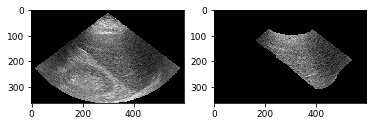

In [406]:
#visualize ground truth only liver portion
liver_test_img_1_h = test_img_1_h * (liver_mask_1)
compare_imgs(m_test_img_1_h, liver_test_img_1_h)

# Simple Thresholding

## Image 1 Experiment

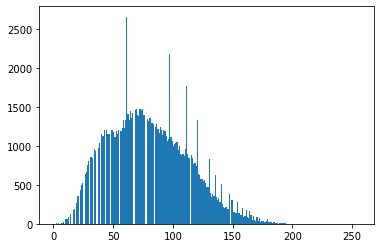

In [313]:
#display histogram of entire image
plt.hist(m_test_img_1_h.ravel(),255,[1,256]); plt.show() #note: only using 1:256 to eliminate black spots from histogram

There is a lot of noise (speckle), so it makes sense to filter the image first (de-noising), and apply thresholding techniques afterwards

Noise in Left Image is: 2.3097233385787925
Noise in Right Image is: 0.08983108197195482


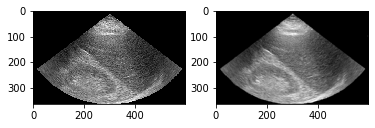

In [314]:
#applying simple 5x5 mean filter
m_test_img_1_h_mean5 = mean_5(m_test_img_1_h)
compare_imgs(m_test_img_1_h, m_test_img_1_h_mean5)

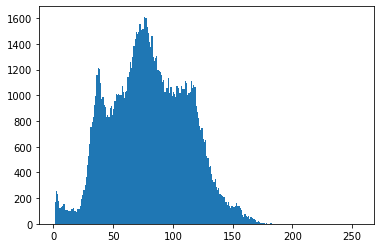

In [315]:
#display histogram of filtered image
plt.hist(m_test_img_1_h_mean5.ravel(),255,[1,256]); plt.show()

This histogram gives slightly more promising results. It is not bi-modal, however it has some distinct peaks, more promising for thresholding techniques.

Another, larger filter will be applied to see how the histogram changes.

Noise in Left Image is: 2.3097233385787925
Noise in Right Image is: 1.0540579056204649


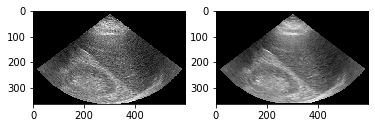

In [316]:
#applying centre-weighted median filter (NOTE: this takes a long time to run)
m_test_img_1_h_cenmed = cen_median(m_test_img_1_h)
compare_imgs(m_test_img_1_h, m_test_img_1_h_cenmed)

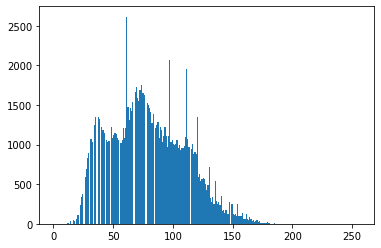

In [47]:
#display histogram of filtered image
plt.hist(m_test_img_1_h_cenmed.ravel(),255,[1,256]); plt.show()

Results from the centre weighted median filter are worse. Instead, we can try a larger mean filter, and perhaps apply some contrast enhancement.

Noise in Left Image is: 2.3097233385787925
Noise in Right Image is: 0.018931048753082158


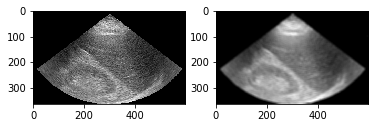

In [317]:
#applying simple 11x11mean filter
m_test_img_1_h_mean11 = mean_11(m_test_img_1_h)
compare_imgs(m_test_img_1_h, m_test_img_1_h_mean11)

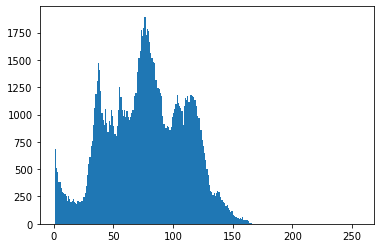

In [318]:
#display histogram of filtered image
plt.hist(m_test_img_1_h_mean11.ravel(),255,[1,256]); plt.show()

Noise in Left Image is: 2.3097233385787925
Noise in Right Image is: 0.05541675957606664


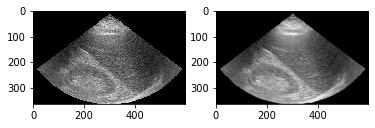

In [319]:
#applying gaussian filter
m_test_img_1_h_gaussian = cv2.GaussianBlur(m_test_img_1_h, (7,7),0)
compare_imgs(m_test_img_1_h, m_test_img_1_h_gaussian)

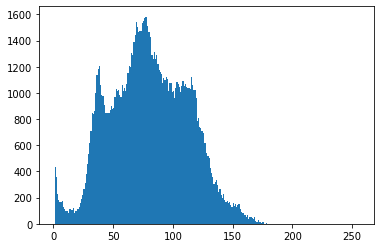

In [320]:
#display histogram of filtered image
plt.hist(m_test_img_1_h_gaussian.ravel(),255,[1,256]); plt.show()

Let's try thresholding this now @25, 50, 98

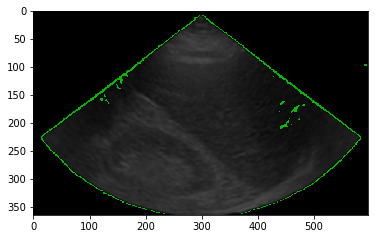

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [321]:
#thresholding on filtered images
thresholding(m_test_img_1_h_mean5, 25, 1)

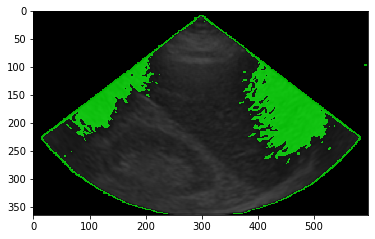

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [322]:
#thresholding on filtered images
thresholding(m_test_img_1_h_mean5, 50, 1)

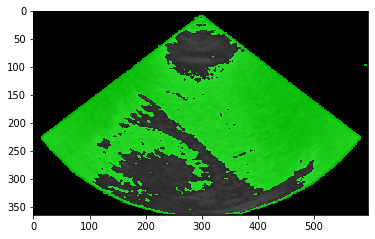

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [323]:
#thresholding on filtered images
thresholding(m_test_img_1_h_mean5, 98, 1)

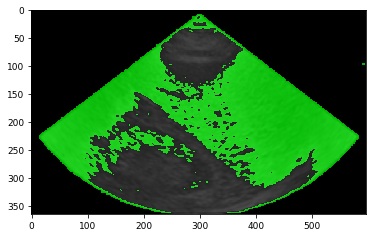

In [379]:
#thresholding on filtered images
thresh_mean = thresholding(m_test_img_1_h_mean5, 85, 1)

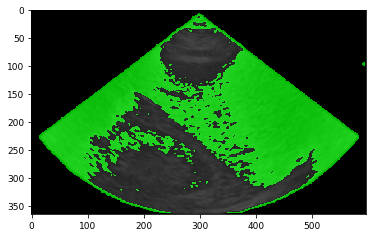

In [380]:
#thresholding on filtered images
thresh_gauss = thresholding(m_test_img_1_h_gaussian, 85, 1)

In [382]:
get_accuracy(thresh_mean, liver_mask_1, mask, 1)

Accuracy for image is: 0.7282343928869609
Accuracy for liver is: 0.855772312557424


(0.7282343928869609, 0.855772312557424)

Looks like some closing techniques will also work well here... Abdullah is working on this

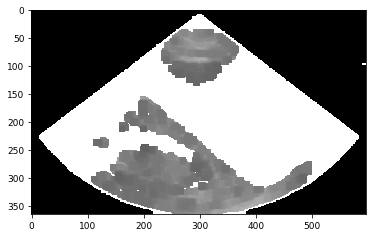

Accuracy for image is: 0.7233712913471222
Accuracy for liver is: 0.9329501506378068


(0.7233712913471222, 0.9329501506378068)

In [386]:
#closing code by abdullah
k1 = np.ones((11,11))
thresh_mean_closed = cv2.morphologyEx(thresh_mean, cv2.MORPH_CLOSE, np.ones((11,11)))
plt.imshow(thresh_mean_closed, cmap = plt.get_cmap('gray'))
plt.show()

get_accuracy(thresh_mean_closed, liver_mask_1, mask, 1)

Great! The accuracy for the image remained the same but accuracy for liver only increased since all the gaps were closed. I will keep this on hold for later, and apply closing as a final step after all segmentation techniques have been applied.

This segmentation captured the liver pretty well! However, this is only for 1 image, and there are several parts captured that are not actually liver (ie. portions of kidney). Also, in reality the liver will have a different intensity value RELATIVE to the kidney based on its disease (fatty livers are brighter than kidney). This is where edge detection will be useful.


IDEA:
Using prior knowledge (ie 1 long line) can help split the image. (above line is liver).
Using prior knowledge (oval shape) can help define a threshold. Abdullah to work on edge detection.

Update: Canny edge detection failed to do what we wanted. We wanted to define the large line the separates liver and kidney.

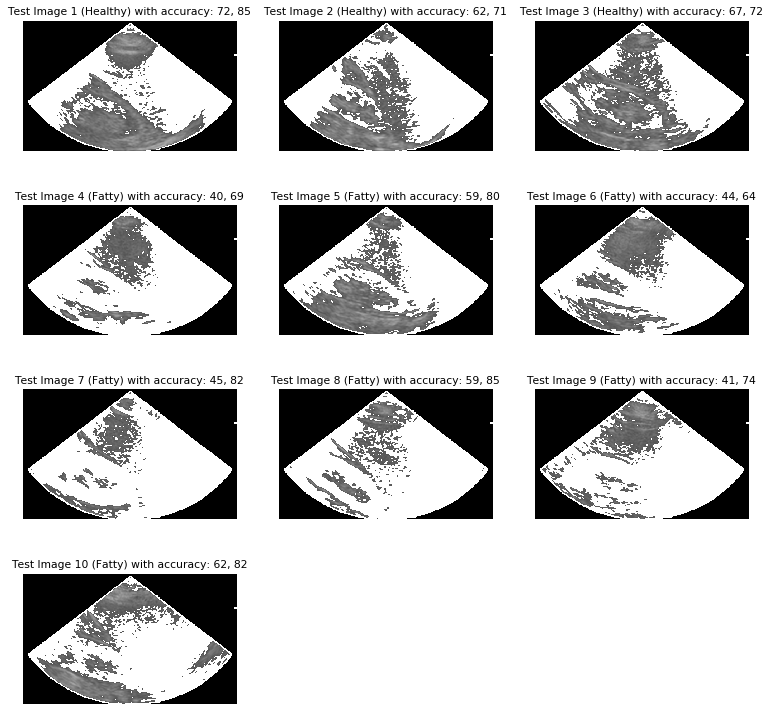

Mean Classification Accuracy is: 55.62759831642008 %
Mean Classification Accuracy for liver only is: 77.00954341744388 %


In [392]:
thresh = 85
m_test_img_1_h_mean5 = mean_5(m_test_img_1_h)
m_test_img_2_h_mean5 = mean_5(m_test_img_2_h)
m_test_img_3_h_mean5 = mean_5(m_test_img_3_h)
m_test_img_4_h_mean5 = mean_5(m_test_img_4_h)
m_test_img_5_h_mean5 = mean_5(m_test_img_5_h)
m_test_img_6_h_mean5 = mean_5(m_test_img_6_h)
m_test_img_7_h_mean5 = mean_5(m_test_img_7_h)
m_test_img_8_h_mean5 = mean_5(m_test_img_8_h)
m_test_img_9_h_mean5 = mean_5(m_test_img_9_h)
m_test_img_10_h_mean5 = mean_5(m_test_img_10_h)

i1 = thresholding(m_test_img_1_h_mean5, thresh, 0)
i2 = thresholding(m_test_img_2_h_mean5, thresh, 0)
i3 = thresholding(m_test_img_3_h_mean5, thresh, 0)
i4 = thresholding(m_test_img_4_h_mean5, thresh, 0)
i5 = thresholding(m_test_img_5_h_mean5, thresh, 0)
i6 = thresholding(m_test_img_6_h_mean5, thresh, 0)
i7 = thresholding(m_test_img_7_h_mean5, thresh, 0)
i8 = thresholding(m_test_img_8_h_mean5, thresh, 0)
i9 = thresholding(m_test_img_9_h_mean5, thresh, 0)
i10 = thresholding(m_test_img_10_h_mean5, thresh, 0)

plot_10(i1, liver_mask_1, i2, liver_mask_2, i3, liver_mask_3, i4, liver_mask_4, i5, liver_mask_5, i6, liver_mask_6, i7, liver_mask_7, i8, liver_mask_8, i9, liver_mask_9, i10, liver_mask_10, mask)

Clearly a single threshold does not hold true for all images. Its also worth noting that the thresholding technique worked better on the first 3 images. The liver is darker than the kidney and is segmented well. The remaining 7 images are from patients diagnosed with fatty liver disease, and thus their livers appear brighter. They are as bright, or brighter than the kidney making it harder to segment. Let me try changing the threshold for diseased liver first.

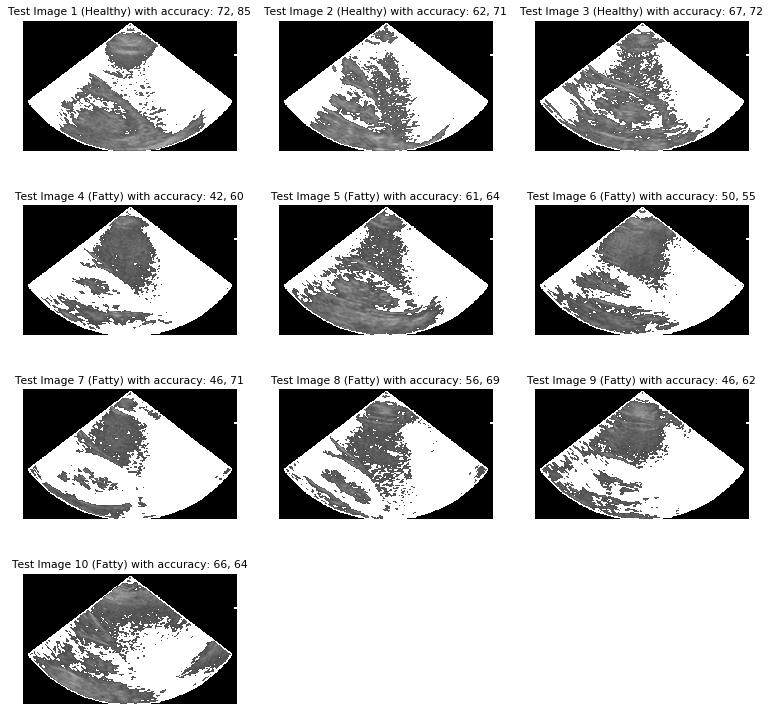

Mean Classification Accuracy is: 57.24860347216842 %
Mean Classification Accuracy for liver only is: 67.8958413481898 %


In [393]:
thresh = 85
thresh_fatty = 75

i1 = thresholding(m_test_img_1_h_mean5, thresh, 0)
i2 = thresholding(m_test_img_2_h_mean5, thresh, 0)
i3 = thresholding(m_test_img_3_h_mean5, thresh, 0)
i4 = thresholding(m_test_img_4_h_mean5, thresh_fatty, 0)
i5 = thresholding(m_test_img_5_h_mean5, thresh_fatty, 0)
i6 = thresholding(m_test_img_6_h_mean5, thresh_fatty, 0)
i7 = thresholding(m_test_img_7_h_mean5, thresh_fatty, 0)
i8 = thresholding(m_test_img_8_h_mean5, thresh_fatty, 0)
i9 = thresholding(m_test_img_9_h_mean5, thresh_fatty, 0)
i10 = thresholding(m_test_img_10_h_mean5, thresh_fatty, 0)

plot_10(i1, liver_mask_1, i2, liver_mask_2, i3, liver_mask_3, i4, liver_mask_4, i5, liver_mask_5, i6, liver_mask_6, i7, liver_mask_7, i8, liver_mask_8, i9, liver_mask_9, i10, liver_mask_10, mask)

It seems like the only way to combat this slightly was to decrease the threshold for diseased livers and capture only the darkest portions. In this way, a lot of the liver is missed.

Now I'll try increasing contrast and doing the same thresholding. (different for fatty and healthy images)

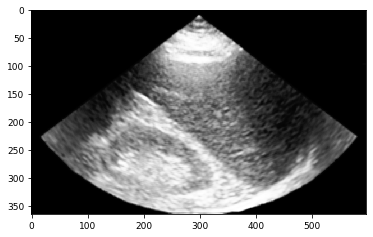

In [394]:
#increase contrast 1 image using histogram equalization
m_test_img_1_h_mean5_new = cv2.equalizeHist(m_test_img_1_h_mean5.astype(np.uint8))
display_img(m_test_img_1_h_mean5_new)

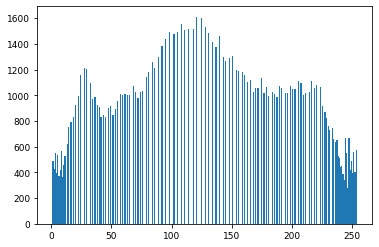

In [395]:
#display histogram of filtered & contrast increased image
plt.hist(m_test_img_1_h_mean5_new.ravel(),254,[1,254]); plt.show()

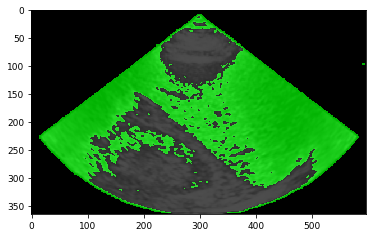

In [396]:
#thresholding on filtered images after increasing contrast
img_after_thresh = thresholding(m_test_img_1_h_mean5_new, 150, 1)

In [397]:
get_accuracy(liver_image_1_thresh, liver_mask_1, mask, 1) #before histogram equalization
get_accuracy(img_after_thresh, liver_mask_1, mask, 1) #after histogram equalization

Accuracy for image is: 0.7282343928869609
Accuracy for liver is: 0.855772312557424
Accuracy for image is: 0.7243008753582771
Accuracy for liver is: 0.8671609580991859


(0.7243008753582771, 0.8671609580991859)

The threshold has to increase significantly after histogram equalization (85 -> 150). The results seem to improve slightly for this image (85% -> 86%). I'll try this on a diseased image now too.

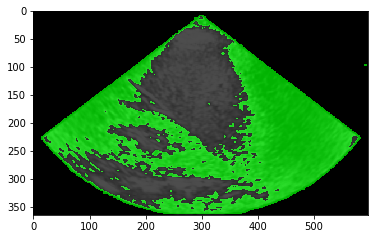

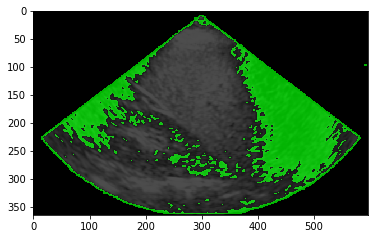

Accuracy for image is: 0.6273400986391923
Accuracy for liver is: 0.41145252550282907
Accuracy for image is: 0.468871846515351
Accuracy for liver is: 0.5401230743815306


(0.468871846515351, 0.5401230743815306)

In [373]:
#increase contrast 4 image using histogram equalization
m_test_img_4_h_mean5_new = cv2.equalizeHist(m_test_img_4_h_mean5.astype(np.uint8))
img_after_thresh4 = thresholding(m_test_img_4_h_mean5_new, 150, 1)
liver_image_4_thresh = thresholding(m_test_img_4_h_mean5_new, 85, 1)
get_accuracy(liver_image_4_thresh, liver_mask_4, mask, 1) #before histogram equalization
get_accuracy(img_after_thresh4, liver_mask_4, mask, 1) #after histogram equalization

Looks like histogram equalization is creating a divide in the liver between shadowed and unshadowed areas. Its exxagerating a feature that we actually want to suppress. I'll try it on all the images anyways now to see if thers a significant improvement there.

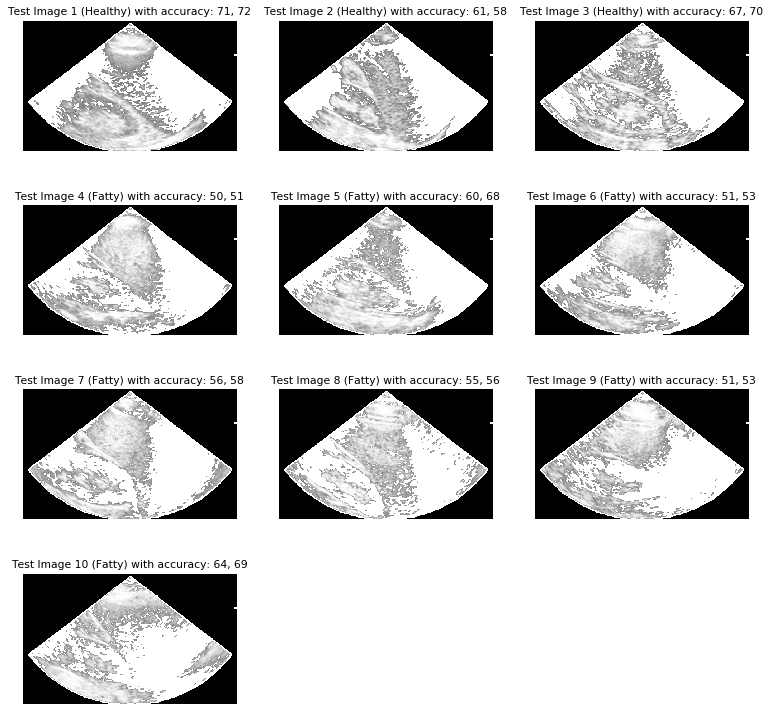

Mean Classification Accuracy is: 59.25314810511186 %
Mean Classification Accuracy for liver only is: 61.27401361731002 %


In [398]:
#increase contrast
m_test_img_1_h_mean5_con = cv2.equalizeHist(m_test_img_1_h_mean5.astype(np.uint8))
m_test_img_2_h_mean5_con = cv2.equalizeHist(m_test_img_2_h_mean5.astype(np.uint8))
m_test_img_3_h_mean5_con = cv2.equalizeHist(m_test_img_3_h_mean5.astype(np.uint8))
m_test_img_4_h_mean5_con = cv2.equalizeHist(m_test_img_4_h_mean5.astype(np.uint8))
m_test_img_5_h_mean5_con = cv2.equalizeHist(m_test_img_5_h_mean5.astype(np.uint8))
m_test_img_6_h_mean5_con = cv2.equalizeHist(m_test_img_6_h_mean5.astype(np.uint8))
m_test_img_7_h_mean5_con = cv2.equalizeHist(m_test_img_7_h_mean5.astype(np.uint8))
m_test_img_8_h_mean5_con = cv2.equalizeHist(m_test_img_8_h_mean5.astype(np.uint8))
m_test_img_9_h_mean5_con = cv2.equalizeHist(m_test_img_9_h_mean5.astype(np.uint8))
m_test_img_10_h_mean5_con = cv2.equalizeHist(m_test_img_10_h_mean5.astype(np.uint8))

thresh = 125
thresh_fatty = 135

i1 = thresholding(m_test_img_1_h_mean5_con, thresh, 0)
i2 = thresholding(m_test_img_2_h_mean5_con, thresh, 0)
i3 = thresholding(m_test_img_3_h_mean5_con, thresh, 0)
i4 = thresholding(m_test_img_4_h_mean5_con, thresh_fatty, 0)
i5 = thresholding(m_test_img_5_h_mean5_con, thresh_fatty, 0)
i6 = thresholding(m_test_img_6_h_mean5_con, thresh_fatty, 0)
i7 = thresholding(m_test_img_7_h_mean5_con, thresh_fatty, 0)
i8 = thresholding(m_test_img_8_h_mean5_con, thresh_fatty, 0)
i9 = thresholding(m_test_img_9_h_mean5_con, thresh_fatty, 0)
i10 = thresholding(m_test_img_10_h_mean5_con, thresh_fatty, 0)

plot_10(i1, liver_mask_1, i2, liver_mask_2, i3, liver_mask_3, i4, liver_mask_4, i5, liver_mask_5, i6, liver_mask_6, i7, liver_mask_7, i8, liver_mask_8, i9, liver_mask_9, i10, liver_mask_10, mask)

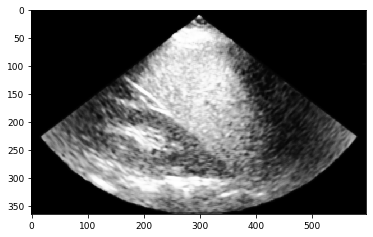

In [400]:
#showing result of contrast enhancement & exxageration of shadowing..
display_img(m_test_img_4_h_mean5_con)

It seems that histogram equalization actually makes the thresholding worse. It seems to divide the liver into 2 distinct brightness values. Its unfortunately capturing all of the darket areas which are actually ultrasound artifacts such as shadowing & exxagerating them. This means one would need to somewhoe capture the darkest and lightest parts in the image. That doesnt really make sense for this segmentation application. I will return back to images before contrast enhancement. As a nect step, I'll create a new thresholding funciton that takes upper and lower bounds.

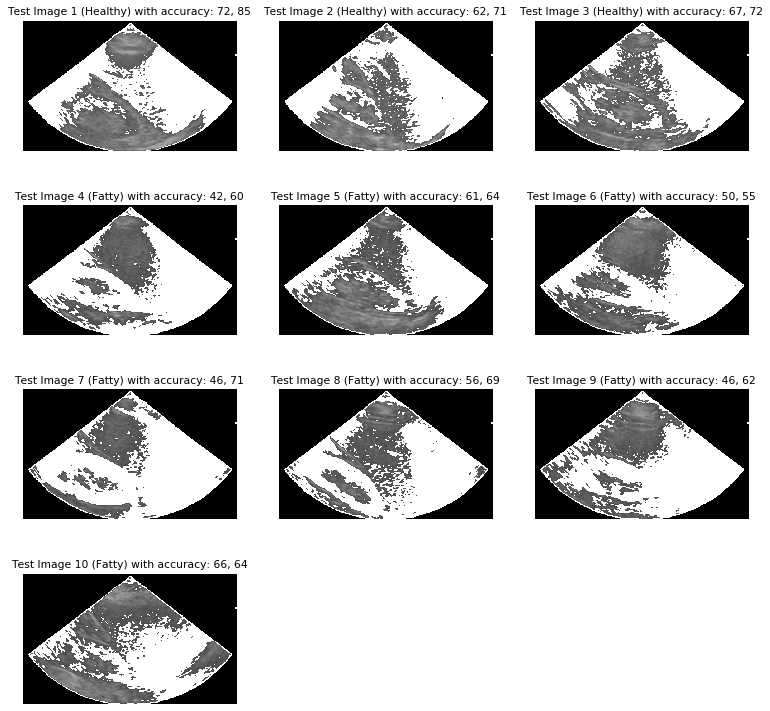

Mean Classification Accuracy is: 57.24886168994931 %
Mean Classification Accuracy for liver only is: 67.88526764912247 %


In [401]:
thresh_low = 10
thresh_high = 85
thresh_fatty_low = 10
thresh_fatty_high = 75

i1 = thresholding_2(m_test_img_1_h_mean5, thresh_low, thresh_high, 0)
i2 = thresholding_2(m_test_img_2_h_mean5, thresh_low, thresh_high, 0)
i3 = thresholding_2(m_test_img_3_h_mean5, thresh_low, thresh_high, 0)
i4 = thresholding_2(m_test_img_4_h_mean5, thresh_fatty_low, thresh_fatty_high, 0)
i5 = thresholding_2(m_test_img_5_h_mean5, thresh_fatty_low, thresh_fatty_high, 0)
i6 = thresholding_2(m_test_img_6_h_mean5, thresh_fatty_low, thresh_fatty_high, 0)
i7 = thresholding_2(m_test_img_7_h_mean5, thresh_fatty_low, thresh_fatty_high, 0)
i8 = thresholding_2(m_test_img_8_h_mean5, thresh_fatty_low, thresh_fatty_high, 0)
i9 = thresholding_2(m_test_img_9_h_mean5, thresh_fatty_low, thresh_fatty_high, 0)
i10 = thresholding_2(m_test_img_10_h_mean5, thresh_fatty_low, thresh_fatty_high, 0)

plot_10(i1, liver_mask_1, i2, liver_mask_2, i3, liver_mask_3, i4, liver_mask_4, i5, liver_mask_5, i6, liver_mask_6, i7, liver_mask_7, i8, liver_mask_8, i9, liver_mask_9, i10, liver_mask_10, mask)

It looks like this is about as good as it will get here, unless i increase the threshold for the fatty liver images. In this case, much more of the image wil be classified as liver: the liver only accuracy will increase, but the mean classification accuracy will decrease.

Let's keep that on hold for now, and try Niblack's thresholding (although im quite certain this will be useless)

### Niblack's Thresholding

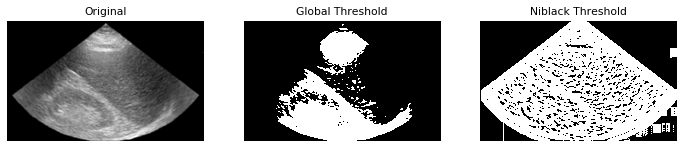

In [685]:
image = m_test_img_1_h_mean5

binary_global = image > 85
window_size = 25

thresh_niblack = threshold_niblack(image, window_size=window_size, k=0.8)
binary_niblack = image > thresh_niblack

#plotting
matplotlib.rcParams['font.size'] = 9
plt.figure(figsize=(12, 12))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Global Threshold')
plt.imshow(binary_global, cmap=plt.cm.gray)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(binary_niblack, cmap=plt.cm.gray)
plt.title('Niblack Threshold')
plt.axis('off')

plt.show()

Just as suspected, Niblack's thresholding is useless for this application. It finds a local threshold for defined windows, and thresholds the entire image. The application isn't useful for large segmentation where there are objects (aka liver).

Thesholding is certainly not enough to define whats liver and what isnt. We need to explore some texture and entropy paramaters.

# Liver vs. Non-Liver Analysis

It looks like edge detection failed. Instead, I'll do liver vs. non-liver analysis by first manually segmenting the image, and analyzing windows in ground truth sections. Sadly, i won't be able to use "majority area above X threshold" or "majority windows above X threshold" to label an output shape. Accuracy we'll be lower and thresholds need to be very specific now to make this work.

In [409]:
#define liver and non-liver

#test image 1
liver_test_img_1_h = test_img_1_h * liver_mask_1
nonliver_test_img_1_h = m_test_img_1_h * (1-liver_mask_1)
#test image 1
liver_test_img_2_h = test_img_2_h * liver_mask_2
nonliver_test_img_2_h = m_test_img_2_h * (1-liver_mask_2)
#test image 1
liver_test_img_3_h = test_img_3_h * liver_mask_3
nonliver_test_img_3_h = m_test_img_3_h * (1-liver_mask_3)
#test image 1
liver_test_img_4_h = test_img_4_h * liver_mask_4
nonliver_test_img_4_h = m_test_img_4_h * (1-liver_mask_4)
#test image 1
liver_test_img_5_h = test_img_5_h * liver_mask_5
nonliver_test_img_5_h = m_test_img_5_h * (1-liver_mask_5)
#test image 1
liver_test_img_6_h = test_img_6_h * liver_mask_6
nonliver_test_img_6_h = m_test_img_6_h * (1-liver_mask_6)
#test image 1
liver_test_img_7_h = test_img_7_h * liver_mask_7
nonliver_test_img_7_h = m_test_img_7_h * (1-liver_mask_7)
#test image 1
liver_test_img_8_h = test_img_8_h * liver_mask_8
nonliver_test_img_8_h = m_test_img_8_h * (1-liver_mask_8)
#test image 1
liver_test_img_9_h = test_img_9_h * liver_mask_9
nonliver_test_img_9_h = m_test_img_9_h * (1-liver_mask_9)
#test image 10
liver_test_img_10_h = test_img_10_h * liver_mask_10
nonliver_test_img_10_h = m_test_img_10_h * (1-liver_mask_10)

Noise in Left Image is: 1.0994032597390235
Noise in Right Image is: 1.683912457421839


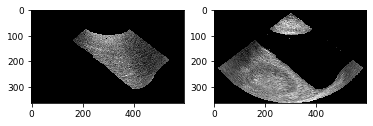

In [410]:
#visualize ground truth non-liver vs. liver
compare_imgs(liver_test_img_1_h, nonliver_test_img_1_h)

### A: NOISE IN LIVER VS NON-LIVER

Problem: more non-liver pixels & noise is additive (expects same size image).
Therefore... area ratios need to be applied for liver vs. non-liver images.

In [411]:
#PROPERTY 1: NOISE
#problem: more non-liver pixels & noise is additive (expects same size image)
#therefore... area ratios need to be applied for liver vs. non-liver images

liver_area = np.shape(np.where(liver_test_img_1_h>0))
liver_area = liver_area[1]
nonliver_area = np.shape(np.where(nonliver_test_img_1_h>0))
nonliver_area = nonliver_area[1]

ratio = nonliver_area/liver_area #(to be multiplied by liver area)

In [412]:
#NEW Functions to display 2 images and noise results IF ratios need to be considered
def compare_imgs_ratio(liver, ratio, nonliver):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(liver, cmap="gray");
    ax[1].imshow(nonliver, cmap="gray");

    noise_old = estimate_noise_ratio(liver, ratio)
    noise_new = estimate_noise(nonliver)

    print("Noise in Liver Image (upscaled) is:", noise_old)
    print("Noise in Non-Liver Image is:", noise_new)
    
def estimate_noise_ratio(I, r):
  H, W = I.shape
  Fil = [[1, -2, 1],
       [-2, 4, -2],
       [1, -2, 1]]
  sigma = r * np.sum(np.sum(np.absolute(convolve2d(I, Fil))))
  sigma = sigma * math.sqrt(0.5 * math.pi) / (6 * (W-2) * (H-2))
  return sigma

Noise in Liver Image (upscaled) is: 1.6314513875531547
Noise in Non-Liver Image is: 1.683912457421839


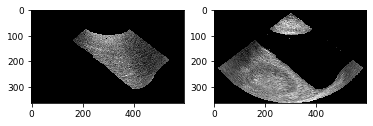

In [413]:
compare_imgs_ratio(liver_test_img_1_h, ratio, nonliver_test_img_1_h)

Those noise values are pretty insignificant... I think in need to segment each section into small boxes, label them as liver and non-liver, and see if there are differences.

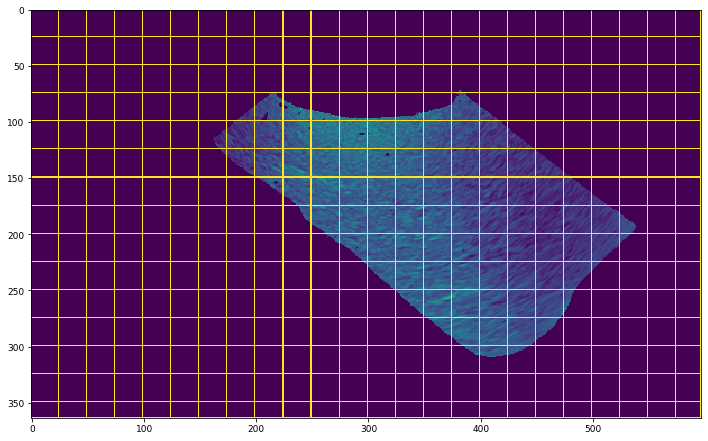

In [414]:
#defining boxes size 25x25
liver_test_img_1_h_boxes = np.copy(liver_test_img_1_h)

for i in range(24):
    column_end = (i*25)-1
    liver_test_img_1_h_boxes[:,column_end] = 255

for j in range(15):
    row_end = (j*25)-1
    liver_test_img_1_h_boxes[row_end,:] = 255

plt.figure(figsize = (12,12))
plt.imshow(liver_test_img_1_h_boxes)

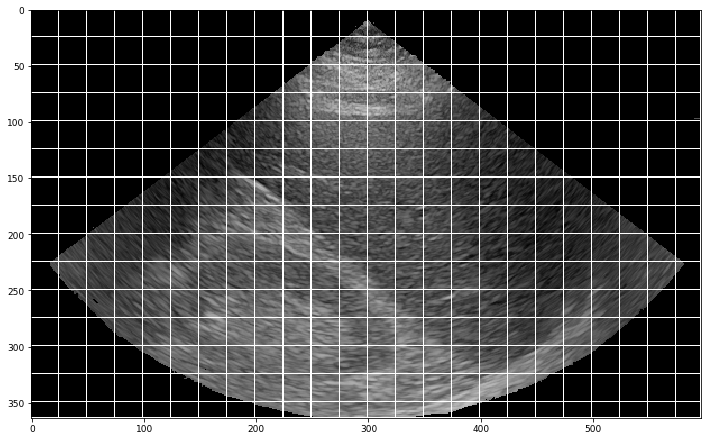

In [684]:
#defining boxes size 25x25
m_test_img_1_h_boxes = np.copy(m_test_img_1_h)

for i in range(24):
    column_end = (i*25)-1
    m_test_img_1_h_boxes[:,column_end] = 255

for j in range(15):
    row_end = (j*25)-1
    m_test_img_1_h_boxes[row_end,:] = 255

plt.figure(figsize = (12,12))
plt.imshow(m_test_img_1_h_boxes, cmap = "gray")

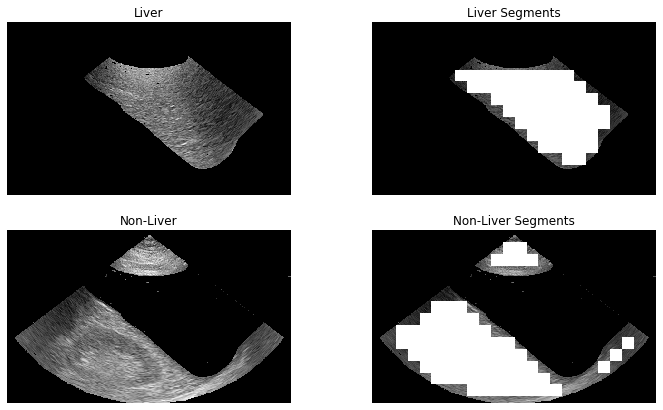

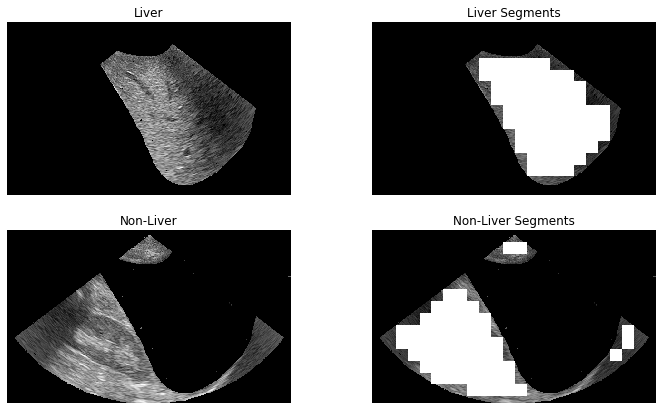

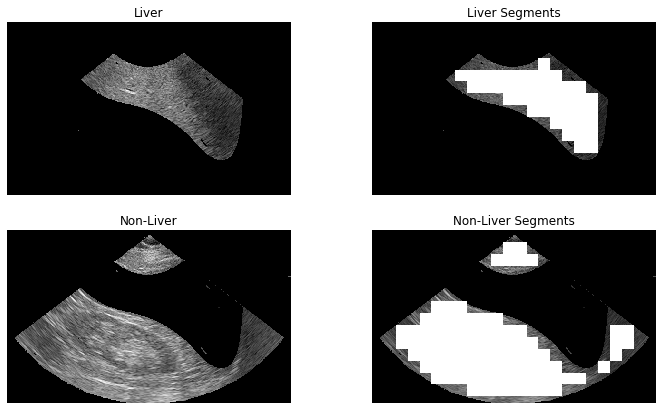

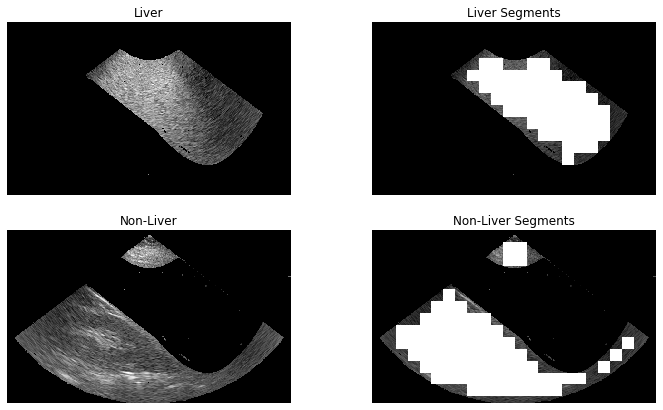

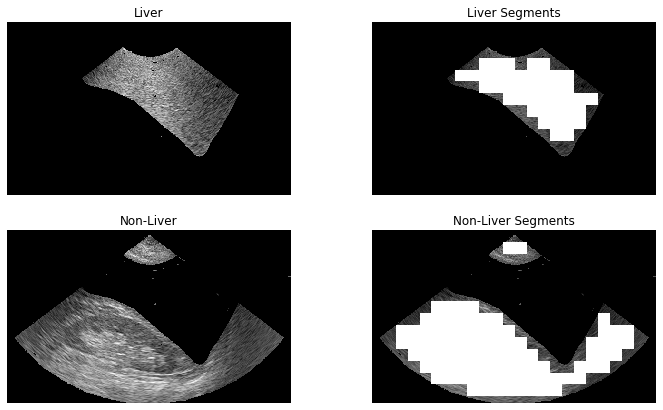

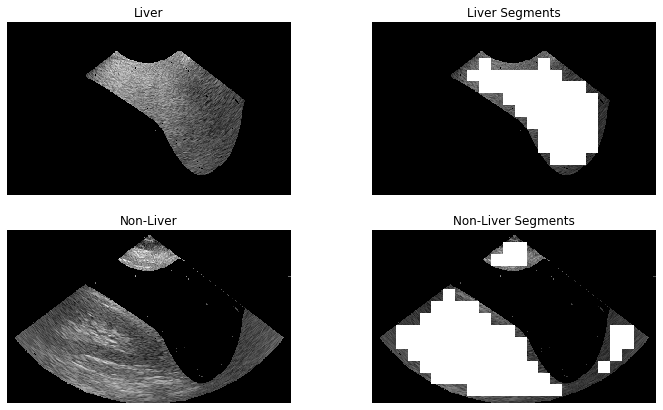

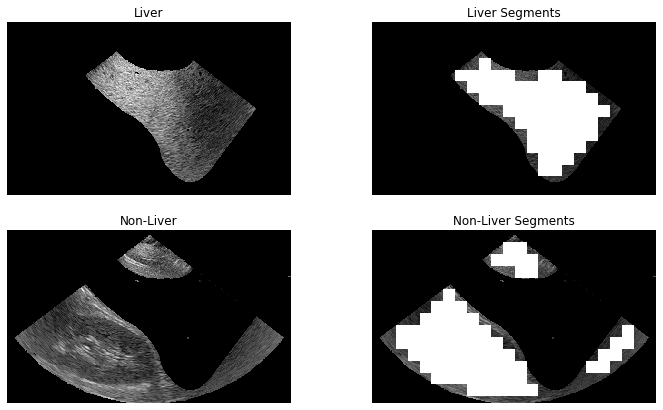

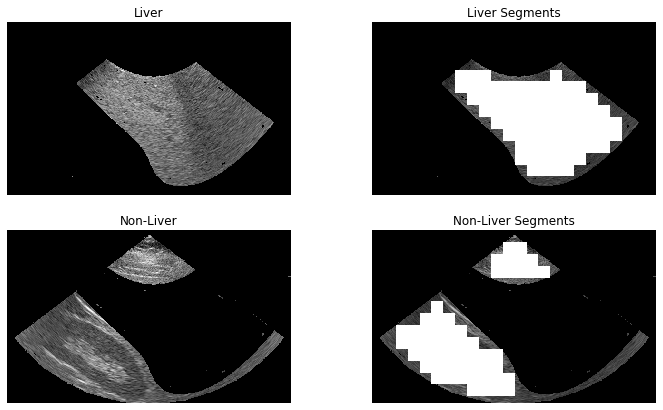

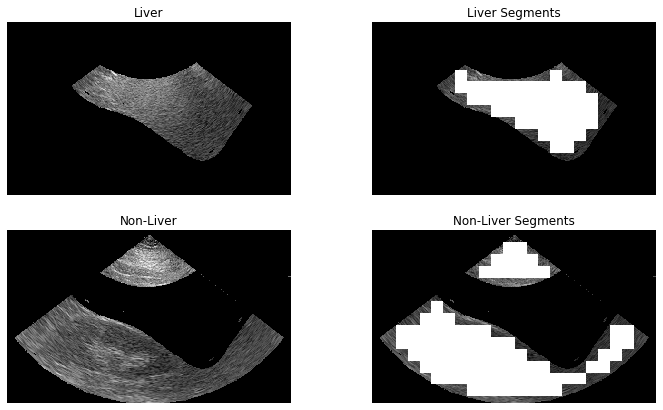

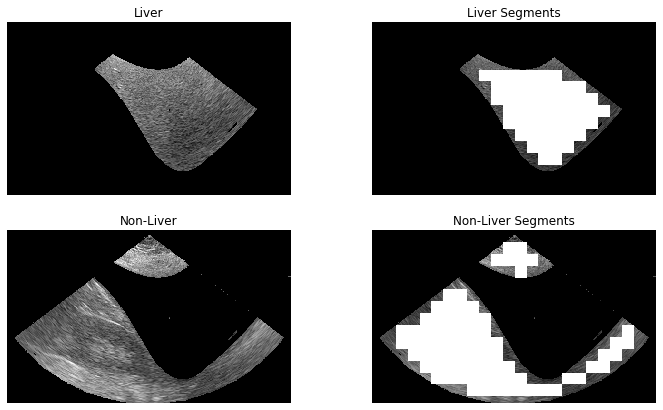

In [483]:
#define boxes that contain liver
windows = 25

#image 1
liver_only_1 = np.copy(liver_test_img_1_h)
nonliver_only_1 = np.copy(nonliver_test_img_1_h)
full_liver_1 = np.copy(m_test_img_1_h)
liver_windows_1, nonliver_windows_1 = find_liver_windows(liver_only_1, nonliver_only_1, windows)
#image 2
liver_only_2 = np.copy(liver_test_img_2_h)
nonliver_only_2 = np.copy(nonliver_test_img_2_h)
full_liver_2 = np.copy(m_test_img_2_h)
liver_windows_2, nonliver_windows_2 = find_liver_windows(liver_only_2, nonliver_only_2, windows)
#image 1
liver_only_3 = np.copy(liver_test_img_3_h)
nonliver_only_3 = np.copy(nonliver_test_img_3_h)
full_liver_3 = np.copy(m_test_img_3_h)
liver_windows_3, nonliver_windows_3 = find_liver_windows(liver_only_3, nonliver_only_3, windows)
#image 1
liver_only_4 = np.copy(liver_test_img_4_h)
nonliver_only_4 = np.copy(nonliver_test_img_4_h)
full_liver_4 = np.copy(m_test_img_4_h)
liver_windows_4, nonliver_windows_4 = find_liver_windows(liver_only_4, nonliver_only_4, windows)
#image 1
liver_only_5 = np.copy(liver_test_img_5_h)
nonliver_only_5 = np.copy(nonliver_test_img_5_h)
full_liver_5 = np.copy(m_test_img_5_h)
liver_windows_5, nonliver_windows_5 = find_liver_windows(liver_only_5, nonliver_only_5, windows)
#image 1
liver_only_6 = np.copy(liver_test_img_6_h)
nonliver_only_6 = np.copy(nonliver_test_img_6_h)
full_liver_6 = np.copy(m_test_img_6_h)
liver_windows_6, nonliver_windows_6 = find_liver_windows(liver_only_6, nonliver_only_6, windows)
#image 1
liver_only_7 = np.copy(liver_test_img_7_h)
nonliver_only_7 = np.copy(nonliver_test_img_7_h)
full_liver_7 = np.copy(m_test_img_7_h)
liver_windows_7, nonliver_windows_7 = find_liver_windows(liver_only_7, nonliver_only_7, windows)
#image 8
liver_only_8 = np.copy(liver_test_img_8_h)
nonliver_only_8 = np.copy(nonliver_test_img_8_h)
full_liver_8 = np.copy(m_test_img_8_h)
liver_windows_8, nonliver_windows_8 = find_liver_windows(liver_only_8, nonliver_only_8, windows)
#image 9
liver_only_9 = np.copy(liver_test_img_9_h)
nonliver_only_9 = np.copy(nonliver_test_img_9_h)
full_liver_9 = np.copy(m_test_img_9_h)
liver_windows_9, nonliver_windows_9 = find_liver_windows(liver_only_9, nonliver_only_9, windows)
#image 10
liver_only_10 = np.copy(liver_test_img_10_h)
nonliver_only_10 = np.copy(nonliver_test_img_10_h)
full_liver_10 = np.copy(m_test_img_10_h)
liver_windows_10, nonliver_windows_10 = find_liver_windows(liver_only_10, nonliver_only_10, windows)

Now, using the liver and non-liver segments, we can calculate properties that vary between liver and non-liver. Later, we can use those properties and thresholds for segmentation. I'll do this analysis on only image 1 to start.

Liver Noise Mean is: 5.332205742326578
Non-Liver Noise Mean is: 5.142151124343339


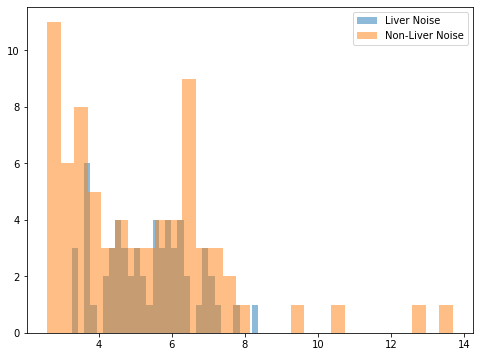

In [484]:
#IMAGE 1 noise in liver vs non-liver windows

noise_liver = []
noise_nonliver = []

for i in range(len(liver_windows_1)):
    [row_start, row_end, column_start, column_end] = liver_windows_1[i]
    noise_liver.append(estimate_noise(full_liver_1[row_start:row_end,column_start:column_end]))

for i in range(len(nonliver_windows_1)):
    [row_start, row_end, column_start, column_end] = nonliver_windows_1[i]
    noise_nonliver.append(estimate_noise(full_liver_1[row_start:row_end,column_start:column_end]))
    
plt.figure(figsize=(8,6))
plt.hist(noise_liver, bins=30, alpha=0.5, label='Liver Noise');
plt.hist(noise_nonliver, bins=30, alpha=0.5, label='Non-Liver Noise');
plt.legend()
print('Liver Noise Mean is:', np.mean(noise_liver))
print('Non-Liver Noise Mean is:', np.mean(noise_nonliver))

Although the means are very similar, the distributions are different. It seems that areas with noise<3 are far more likely to be non-liver.

### B: ENTROPY IN LIVER VS. NON-LIVER

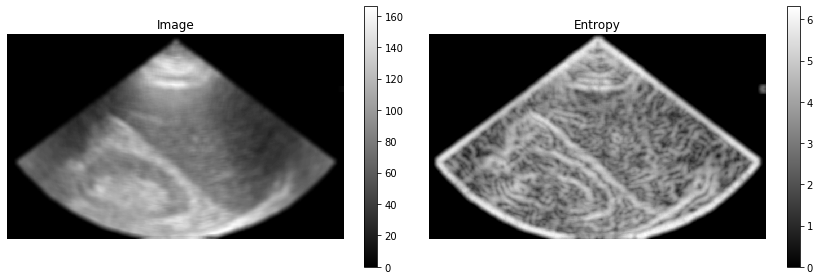

In [485]:
#reference: https://scikit-image.org/docs/dev/auto_examples/filters/plot_entropy.html

#image = img_as_ubyte(np.uint8(np.copy(m_test_img_1_h)))
#image = img_as_ubyte(np.uint8(np.copy(m_test_img_1_h_mean5)))
image = img_as_ubyte(np.uint8(np.copy(m_test_img_1_h_mean11)))

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4), sharex=True, sharey=True)

img0 = ax0.imshow(image, cmap=plt.cm.gray); ax0.set_title("Image"); ax0.axis("off"); fig.colorbar(img0, ax=ax0)
img1 = ax1.imshow(entropy(image, disk(5)), cmap='gray'); ax1.set_title("Entropy"); ax1.axis("off"); fig.colorbar(img1, ax=ax1)

fig.tight_layout()
plt.show()

This is interesting, looks like entropy can be used for edge detection too...

I'm going to try entropy detection on liver and non-liver windows to see if theres anything significant.

Liver Entropy Mean is: 5.448049676733828
Non-Liver Entropy Mean is: 5.8098919305554375


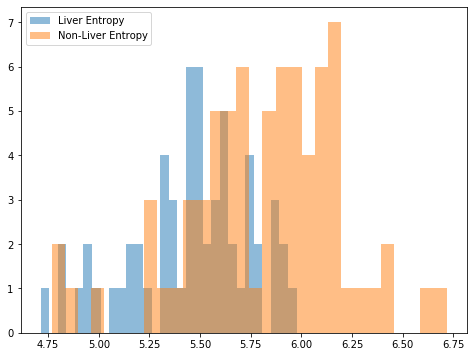

In [486]:
entropy_liver = []
entropy_nonliver = []

for i in range(len(liver_windows_1)):
    [row_start, row_end, column_start, column_end] = liver_windows_1[i]
    entropy_liver.append(skimage.measure.shannon_entropy(full_liver_1[row_start:row_end,column_start:column_end]))

for i in range(len(nonliver_windows_1)):
    [row_start, row_end, column_start, column_end] = nonliver_windows_1[i]
    entropy_nonliver.append(skimage.measure.shannon_entropy(full_liver_1[row_start:row_end,column_start:column_end]))
    
plt.figure(figsize=(8,6))
plt.hist(entropy_liver, bins=30, alpha=0.5, label='Liver Entropy');
plt.hist(entropy_nonliver, bins=30, alpha=0.5, label='Non-Liver Entropy');
plt.legend()
print('Liver Entropy Mean is:', np.mean(entropy_liver))
print('Non-Liver Entropy Mean is:', np.mean(entropy_nonliver))

Wow!! Liver entropy is defenitly higher than non-liver. I need to see if this holds true for other images & test out entropy segmentation.

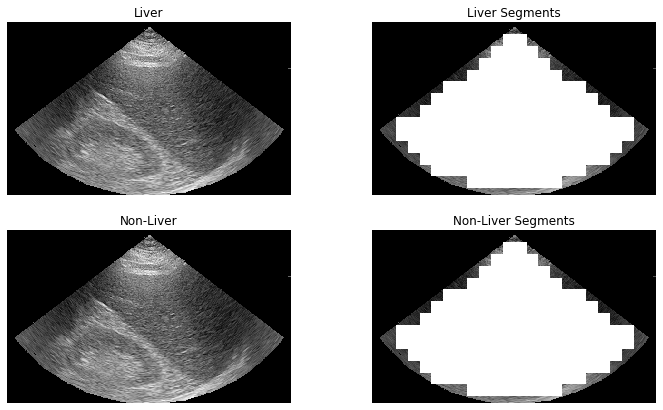

(-0.5, 596.5, 363.5, -0.5)

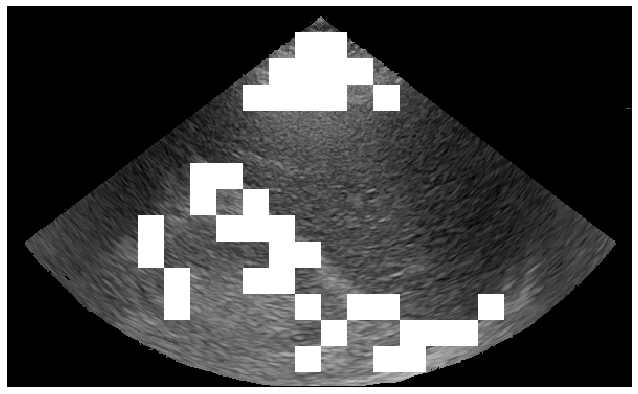

In [487]:
#IMAGE 1 quick test for entropy segmentation
full_liver_entropy_thresh_1 = np.copy(m_test_img_1_h)

#get windows for full image
full_liver_windows, full_liver_windows_2 = find_liver_windows(full_liver_1, full_liver_1, 25)

#define entropy threshold (for non-liver)
entropy_thresh = 6
entropy_liver_1 = []

for i in range(len(full_liver_windows)):
    [row_start, row_end, column_start, column_end] = full_liver_windows_2[i]
    entropy_liver_1.append(skimage.measure.shannon_entropy(full_liver_entropy_thresh_1[row_start:row_end,column_start:column_end]))

for i in range(len(full_liver_windows)):
    if entropy_liver_1[i] > entropy_thresh:
        [row_start, row_end, column_start, column_end] = full_liver_windows_2[i]
        full_liver_entropy_thresh_1[row_start:row_end,column_start:column_end] = 255

plt.figure(figsize=(12, 7))
plt.imshow(full_liver_entropy_thresh_1, cmap=plt.cm.gray)
plt.axis('off')

Cool! So it's accurately defined some areas that are non-liver (skin). I should also try this with smaller windows.

For now, I can compare to the best segmentation based on intensity thresholding.

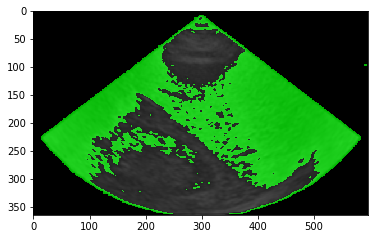

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [488]:
thresholding(m_test_img_1_h_mean5, 85, 1)

This is good. Looks like the entropy thresholding will get rid of the areas that are misclassified by intensity thresholding (skin). I need to create some sort of combo between the 2.

I'll also try the opposite, to classify liver only...

(-0.5, 596.5, 363.5, -0.5)

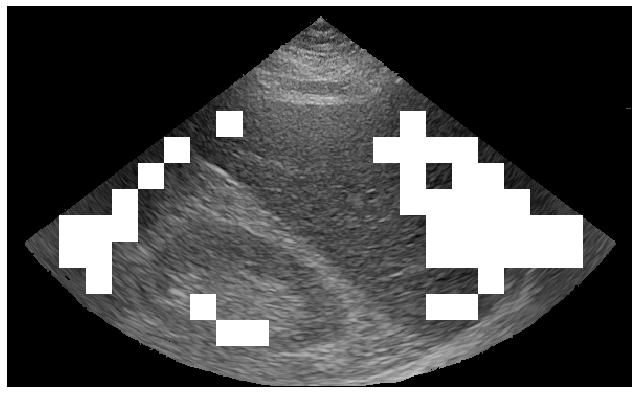

In [492]:
#IMAGE 1 quick test for entropy segmentation
full_liver_entropy_thresh_1 = np.copy(m_test_img_1_h)

#define entropy threshold (for non-liver)
entropy_thresh = 5.45
entropy_liver_1 = []

for i in range(len(full_liver_windows)):
    [row_start, row_end, column_start, column_end] = full_liver_windows_2[i]
    entropy_liver_1.append(skimage.measure.shannon_entropy(full_liver_entropy_thresh_1[row_start:row_end,column_start:column_end]))

for i in range(len(full_liver_windows)):
    if entropy_liver_1[i] < entropy_thresh:
        [row_start, row_end, column_start, column_end] = full_liver_windows_2[i]
        full_liver_entropy_thresh_1[row_start:row_end,column_start:column_end] = 255

plt.figure(figsize=(12, 7))
plt.imshow(full_liver_entropy_thresh_1, cmap=plt.cm.gray)
plt.axis('off')

This doesnt work as well in defining liver (obviouslt because theres so many overlaps in the histogram here). It gets the darkest parts which was already easy to do with thresholding. Let me see if this entropy thresholding holds true for more images.

(-0.5, 596.5, 363.5, -0.5)

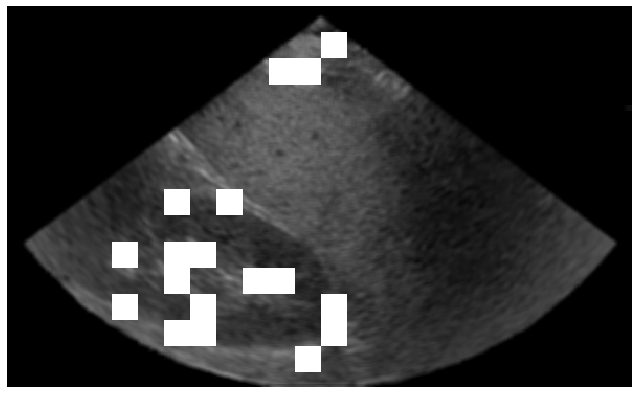

In [536]:
#i used this cell to test entropy thresh on various images
imgx = np.copy(m_test_img_7_h_mean5) #select image here

#define entropy threshold (for non-liver)
entropy_thresh = 9.14 #(keeping this at 6 from image 1)
entropy_liver_x = []

for i in range(len(full_liver_windows)):
    [row_start, row_end, column_start, column_end] = full_liver_windows_2[i]
    entropy_liver_x.append(skimage.measure.shannon_entropy(imgx[row_start:row_end,column_start:column_end]))

for i in range(len(full_liver_windows)):
    if entropy_liver_x[i] > entropy_thresh:
        [row_start, row_end, column_start, column_end] = full_liver_windows_2[i]
        imgx[row_start:row_end,column_start:column_end] = 255

plt.figure(figsize=(12, 7))
plt.imshow(imgx, cmap=plt.cm.gray)
plt.axis('off')

ENTROPY NOTES FOR EACH IMAGE: ***these notes were taken before i was using the mean filtered images... inthe code above i used mean filtered and determined that the best threshold is 9.14

1 - Entropy 6 worked well, defined some non-liver well (skin and edge of liver)


2 & 3 - Entropy 6.1 worked just as well as for image 1

4 & 6 & 7 & 8 & 9 & 10 - Entropy 5.9 worked best

5 - Entropy 5.9 worked extremely well a detecting non-liver

I'll now do a quick test to see if smaller windows are better.

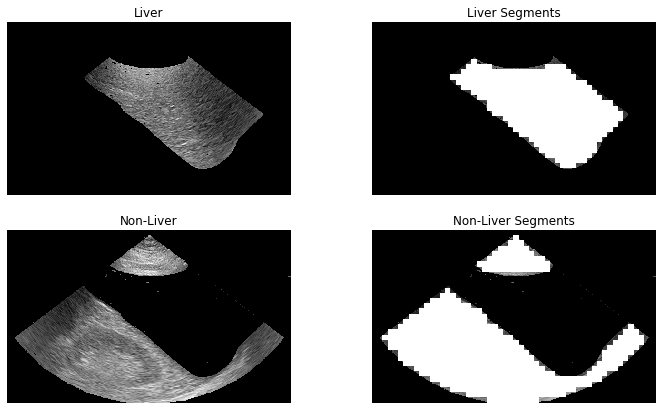

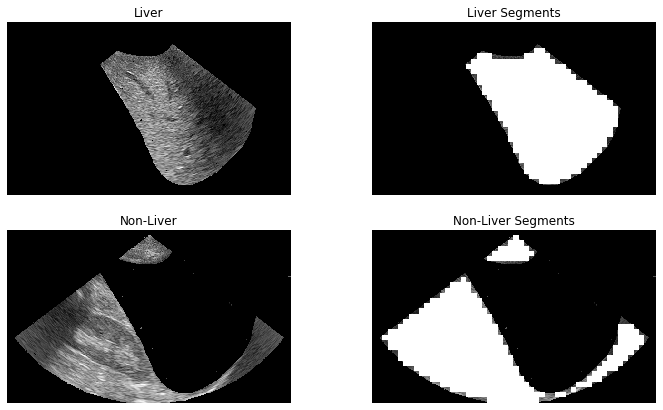

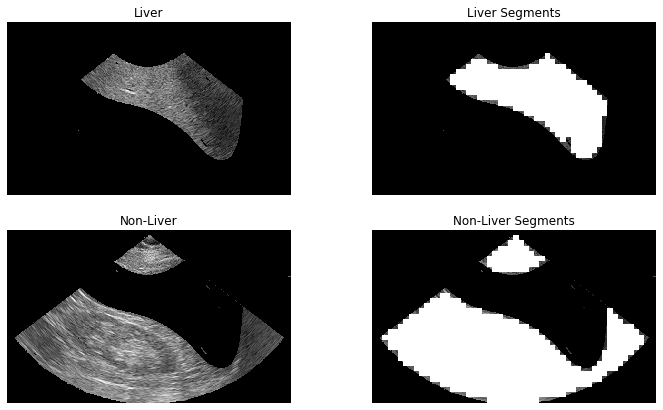

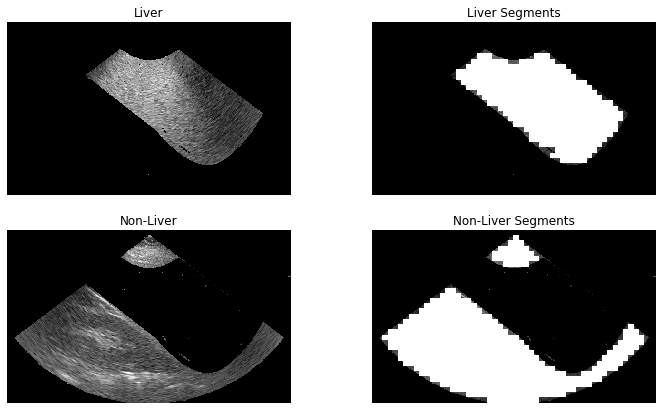

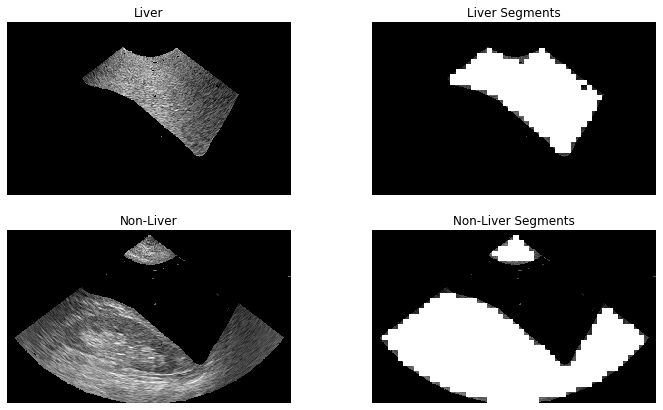

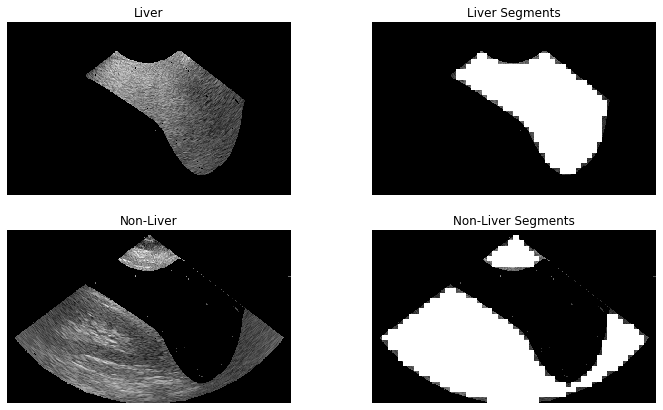

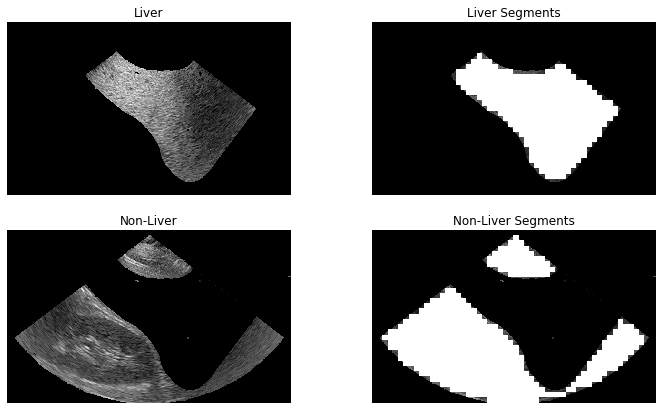

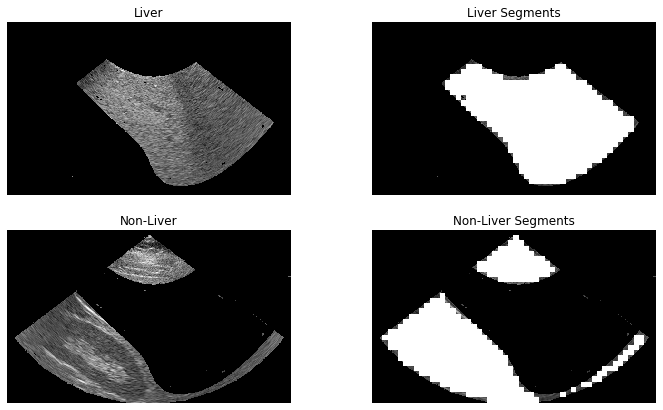

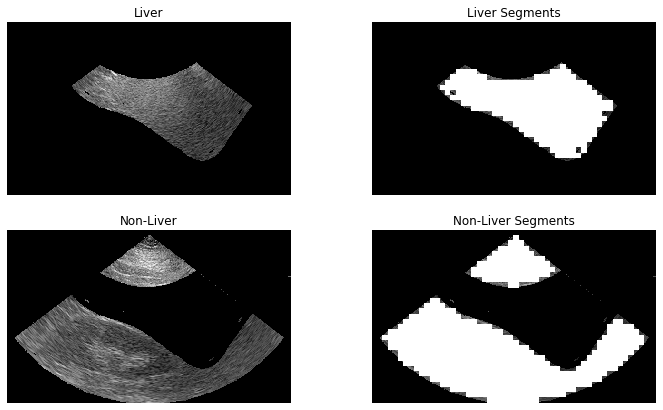

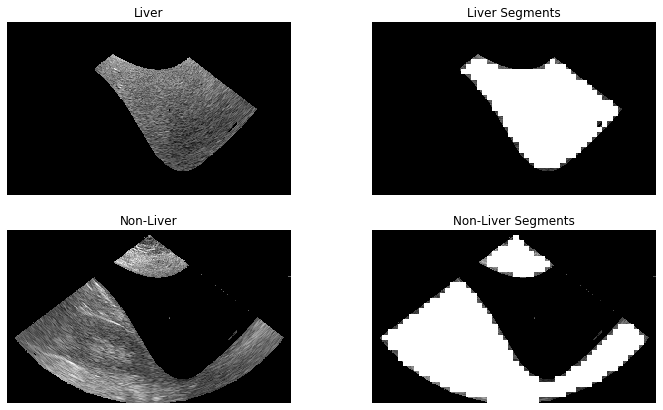

In [453]:
#define boxes that contain liver with smaller windows
windows = 11

#image 1
liver_only_1 = np.copy(liver_test_img_1_h)
nonliver_only_1 = np.copy(nonliver_test_img_1_h)
full_liver_1 = np.copy(m_test_img_1_h)
liver_windows_1, nonliver_windows_1 = find_liver_windows(liver_only_1, nonliver_only_1, windows)
#image 2
liver_only_2 = np.copy(liver_test_img_2_h)
nonliver_only_2 = np.copy(nonliver_test_img_2_h)
full_liver_2 = np.copy(m_test_img_2_h)
liver_windows_2, nonliver_windows_2 = find_liver_windows(liver_only_2, nonliver_only_2, windows)
#image 1
liver_only_3 = np.copy(liver_test_img_3_h)
nonliver_only_3 = np.copy(nonliver_test_img_3_h)
full_liver_3 = np.copy(m_test_img_3_h)
liver_windows_3, nonliver_windows_3 = find_liver_windows(liver_only_3, nonliver_only_3, windows)
#image 1
liver_only_4 = np.copy(liver_test_img_4_h)
nonliver_only_4 = np.copy(nonliver_test_img_4_h)
full_liver_4 = np.copy(m_test_img_4_h)
liver_windows_4, nonliver_windows_4 = find_liver_windows(liver_only_4, nonliver_only_4, windows)
#image 1
liver_only_5 = np.copy(liver_test_img_5_h)
nonliver_only_5 = np.copy(nonliver_test_img_5_h)
full_liver_5 = np.copy(m_test_img_5_h)
liver_windows_5, nonliver_windows_5 = find_liver_windows(liver_only_5, nonliver_only_5, windows)
#image 1
liver_only_6 = np.copy(liver_test_img_6_h)
nonliver_only_6 = np.copy(nonliver_test_img_6_h)
full_liver_6 = np.copy(m_test_img_6_h)
liver_windows_6, nonliver_windows_6 = find_liver_windows(liver_only_6, nonliver_only_6, windows)
#image 1
liver_only_7 = np.copy(liver_test_img_7_h)
nonliver_only_7 = np.copy(nonliver_test_img_7_h)
full_liver_7 = np.copy(m_test_img_7_h)
liver_windows_7, nonliver_windows_7 = find_liver_windows(liver_only_7, nonliver_only_7, windows)
#image 8
liver_only_8 = np.copy(liver_test_img_8_h)
nonliver_only_8 = np.copy(nonliver_test_img_8_h)
full_liver_8 = np.copy(m_test_img_8_h)
liver_windows_8, nonliver_windows_8 = find_liver_windows(liver_only_8, nonliver_only_8, windows)
#image 9
liver_only_9 = np.copy(liver_test_img_9_h)
nonliver_only_9 = np.copy(nonliver_test_img_9_h)
full_liver_9 = np.copy(m_test_img_9_h)
liver_windows_9, nonliver_windows_9 = find_liver_windows(liver_only_9, nonliver_only_9, windows)
#image 10
liver_only_10 = np.copy(liver_test_img_10_h)
nonliver_only_10 = np.copy(nonliver_test_img_10_h)
full_liver_10 = np.copy(m_test_img_10_h)
liver_windows_10, nonliver_windows_10 = find_liver_windows(liver_only_10, nonliver_only_10, windows)

Liver Entropy Mean is: 5.022716347632415
Non-Liver Entropy Mean is: 5.20810126204205


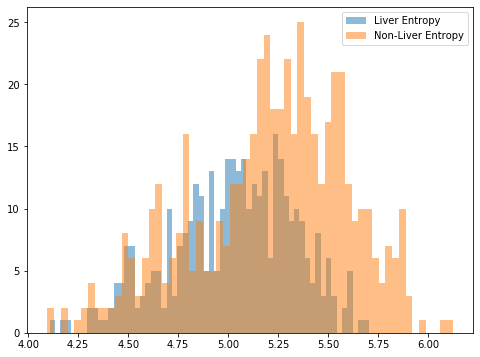

In [455]:
entropy_liver = []
entropy_nonliver = []

for i in range(len(liver_windows_1)):
    [row_start, row_end, column_start, column_end] = liver_windows_1[i]
    entropy_liver.append(skimage.measure.shannon_entropy(full_liver_1[row_start:row_end,column_start:column_end]))

for i in range(len(nonliver_windows_1)):
    [row_start, row_end, column_start, column_end] = nonliver_windows_1[i]
    entropy_nonliver.append(skimage.measure.shannon_entropy(full_liver_1[row_start:row_end,column_start:column_end]))
    
plt.figure(figsize=(8,6))
plt.hist(entropy_liver, bins=60, alpha=0.5, label='Liver Entropy');
plt.hist(entropy_nonliver, bins=60, alpha=0.5, label='Non-Liver Entropy');
plt.legend()
print('Liver Entropy Mean is:', np.mean(entropy_liver))
print('Non-Liver Entropy Mean is:', np.mean(entropy_nonliver))

This looks about the same as before or actually less distint, let see the result on the images...

In [ ]:
#get windows for full image
full_liver_windows, full_liver_windows_2 = find_liver_windows(full_liver_1, full_liver_1, 11)

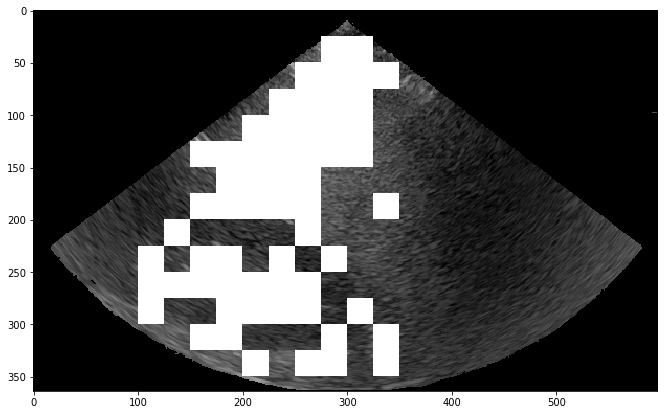

In [538]:
#IMAGE 1 quick test for entropy segmentation

#i used this cell to test entropy thresh on various images for SMALLER WINDOWS
imgx = np.copy(m_test_img_7_h) #select image here

#define entropy threshold (for non-liver)
entropy_thresh = 5.7 #(keeping this at 6 from image 1)
entropy_liver_x = []

for i in range(len(full_liver_windows)):
    [row_start, row_end, column_start, column_end] = full_liver_windows_2[i]
    entropy_liver_x.append(skimage.measure.shannon_entropy(imgx[row_start:row_end,column_start:column_end]))

for i in range(len(full_liver_windows)):
    if entropy_liver_x[i] > entropy_thresh:
        [row_start, row_end, column_start, column_end] = full_liver_windows_2[i]
        imgx[row_start:row_end,column_start:column_end] = 255

plt.figure(figsize=(12, 7))
plt.imshow(imgx, cmap=plt.cm.gray)

Seems to work okay too, but wont eliminate as much as i want with the larger windows.

I'm going to bring back the thresholding results, and remove what entropy detection defined as non-liver. I'll write a function that takes the results of thresholding, calculates entropy and removes what we found was most likely to be  non-liver. This might also give the opportunity to increase fatty liver thresholds again. Recall that accuracies were 57% & 86% at best for full image and liver only resepectively.

I want to use a combination of prior knowledge ant entropy detection to eliminate the bottom left entirely of the image in liver detection. Therefore, I'll do a specific search with the entropy thresholded windows, and ensure that all windows below and to the left of an entropy window is classified as "non-liver" and overrides the thresholding function.

In [ ]:
#get windows for full image
full_liver_windows, full_liver_windows_2 = find_liver_windows(full_liver_1, full_liver_1, 25)

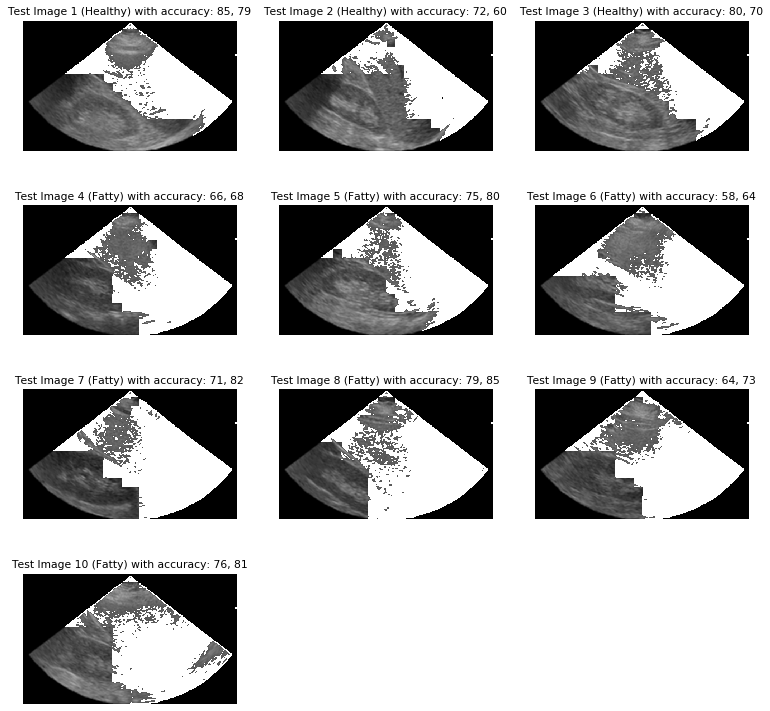

Mean Classification Accuracy is: 73.13717389246091 %
Mean Classification Accuracy for liver only is: 74.84706363618946 %


In [594]:
#show combo result of thresholding and entropy

#NOTE: this takes a while to run!
thresh_low = 10
thresh_high = 85
thresh_fatty_low = 10
thresh_fatty_high = 85

i1 = thresholding_2(m_test_img_1_h_mean5, thresh_low, thresh_high, 0)
i1 = entropy_thresh_combo(m_test_img_1_h_mean5, i1, full_liver_windows)
i2 = thresholding_2(m_test_img_2_h_mean5, thresh_low, thresh_high, 0)
i2 = entropy_thresh_combo(m_test_img_2_h_mean5, i2, full_liver_windows)
i3 = thresholding_2(m_test_img_3_h_mean5, thresh_low, thresh_high, 0)
i3 = entropy_thresh_combo(m_test_img_3_h_mean5, i3, full_liver_windows)
i4 = thresholding_2(m_test_img_4_h_mean5, thresh_fatty_low, thresh_fatty_high, 0)
i4 = entropy_thresh_combo(m_test_img_4_h_mean5, i4, full_liver_windows)
i5 = thresholding_2(m_test_img_5_h_mean5, thresh_fatty_low, thresh_fatty_high, 0)
i5 = entropy_thresh_combo(m_test_img_5_h_mean5, i5, full_liver_windows)
i6 = thresholding_2(m_test_img_6_h_mean5, thresh_fatty_low, thresh_fatty_high, 0)
i6 = entropy_thresh_combo(m_test_img_6_h_mean5, i6, full_liver_windows)
i7 = thresholding_2(m_test_img_7_h_mean5, thresh_fatty_low, thresh_fatty_high, 0)
i7 = entropy_thresh_combo(m_test_img_7_h_mean5, i7, full_liver_windows)
i8 = thresholding_2(m_test_img_8_h_mean5, thresh_fatty_low, thresh_fatty_high, 0)
i8 = entropy_thresh_combo(m_test_img_8_h_mean5, i8, full_liver_windows)
i9 = thresholding_2(m_test_img_9_h_mean5, thresh_fatty_low, thresh_fatty_high, 0)
i9 = entropy_thresh_combo(m_test_img_9_h_mean5, i9, full_liver_windows)
i10 = thresholding_2(m_test_img_10_h_mean5, thresh_fatty_low, thresh_fatty_high, 0)
i10 = entropy_thresh_combo(m_test_img_10_h_mean5, i10, full_liver_windows)

plot_10(i1, liver_mask_1, i2, liver_mask_2, i3, liver_mask_3, i4, liver_mask_4, i5, liver_mask_5, i6, liver_mask_6, i7, liver_mask_7, i8, liver_mask_8, i9, liver_mask_9, i10, liver_mask_10, mask)

This is great! 73% is a huge upgrade from 57%! The combination between entropy thresholding and intensity thresholding gives a great result. Let's apply closing as a final step to improve the accuracy.

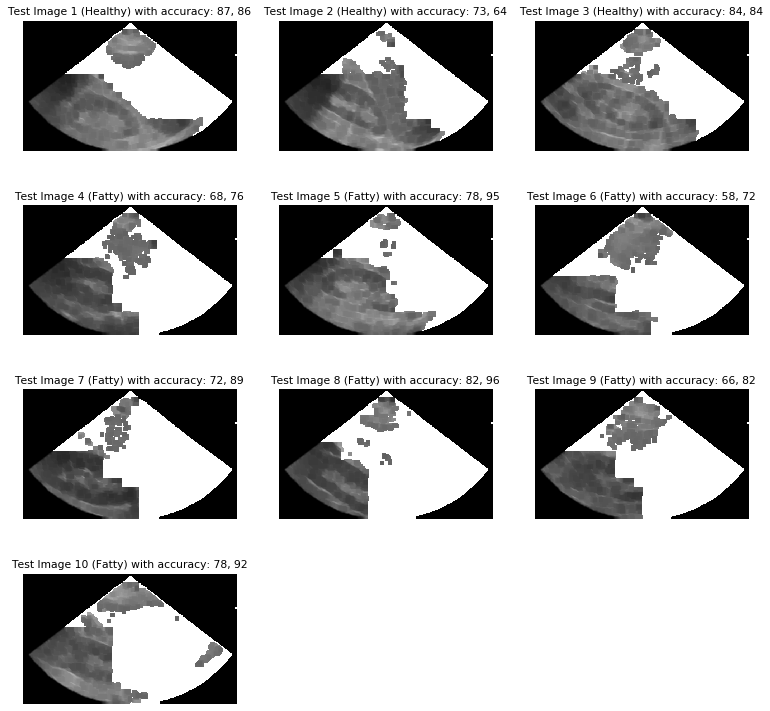

Mean Classification Accuracy is: 75.16581885161946 %
Mean Classification Accuracy for liver only is: 84.0500783501881 %


In [595]:
i1 = cv2.morphologyEx(i1, cv2.MORPH_CLOSE, np.ones((11,11)))
i2 = cv2.morphologyEx(i2, cv2.MORPH_CLOSE, np.ones((11,11)))
i3 = cv2.morphologyEx(i3, cv2.MORPH_CLOSE, np.ones((11,11)))
i4 = cv2.morphologyEx(i4, cv2.MORPH_CLOSE, np.ones((11,11)))
i5 = cv2.morphologyEx(i5, cv2.MORPH_CLOSE, np.ones((11,11)))
i6 = cv2.morphologyEx(i6, cv2.MORPH_CLOSE, np.ones((11,11)))
i7 = cv2.morphologyEx(i7, cv2.MORPH_CLOSE, np.ones((11,11)))
i8 = cv2.morphologyEx(i8, cv2.MORPH_CLOSE, np.ones((11,11)))
i9 = cv2.morphologyEx(i9, cv2.MORPH_CLOSE, np.ones((11,11)))
i10 = cv2.morphologyEx(i10, cv2.MORPH_CLOSE, np.ones((11,11)))

plot_10(i1, liver_mask_1, i2, liver_mask_2, i3, liver_mask_3, i4, liver_mask_4, i5, liver_mask_5, i6, liver_mask_6, i7, liver_mask_7, i8, liver_mask_8, i9, liver_mask_9, i10, liver_mask_10, mask)

This is great! Up to 75% and 84% after closing is applied.

## C: Standard Deviation

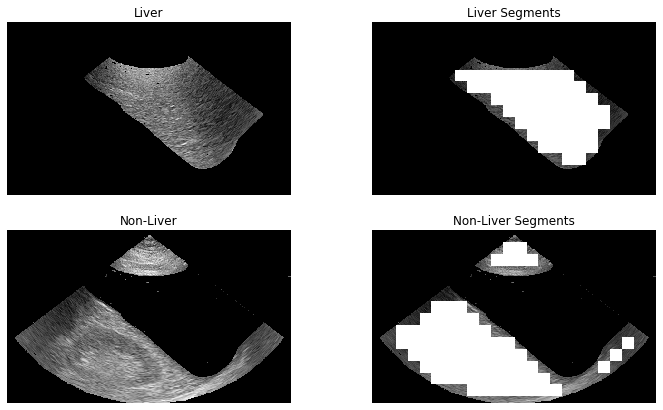

In [608]:
#image 1
windows = 25
liver_only_1 = np.copy(liver_test_img_1_h)
nonliver_only_1 = np.copy(nonliver_test_img_1_h)
full_liver_1 = np.copy(m_test_img_1_h)
liver_windows_1, nonliver_windows_1 = find_liver_windows(liver_only_1, nonliver_only_1, windows)

In [ ]:
#get windows for full image
full_liver_windows, full_liver_windows_2 = find_liver_windows(full_liver_1, full_liver_1, windows)

Liver STD Mean is: 13.203389830508474
Non-Liver STD Mean is: 16.767123287671232


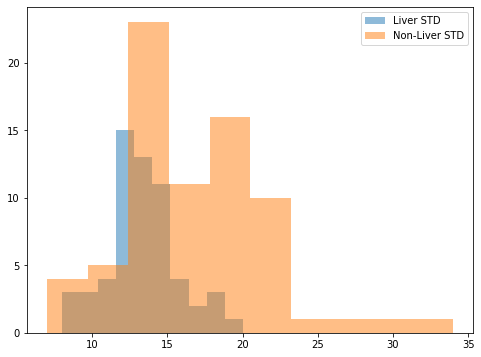

In [624]:
# plot histograms to check if standard deviation has any value
std_liver = []
std_nonliver = []

for i in range(len(liver_windows_1)):
    [row_start, row_end, column_start, column_end] = liver_windows_1[i]
    mean, std = cv2.meanStdDev(full_liver_1[row_start:row_end,column_start:column_end])
    std_liver.append(int(std))

for i in range(len(nonliver_windows_1)):
    [row_start, row_end, column_start, column_end] = nonliver_windows_1[i]
    mean, std = cv2.meanStdDev(full_liver_1[row_start:row_end,column_start:column_end])
    std_nonliver.append(int(std))
    
plt.figure(figsize=(8,6))
plt.hist(std_liver, alpha=0.5, label='Liver STD');
plt.hist(std_nonliver, alpha=0.5, label='Non-Liver STD');
plt.legend()
print('Liver STD Mean is:', np.mean(std_liver))
print('Non-Liver STD Mean is:', np.mean(std_nonliver))

Looks like standard deviation > 20 is defenitly non-liver. Let's see if this produces more useful result than entropy.

(-0.5, 596.5, 363.5, -0.5)

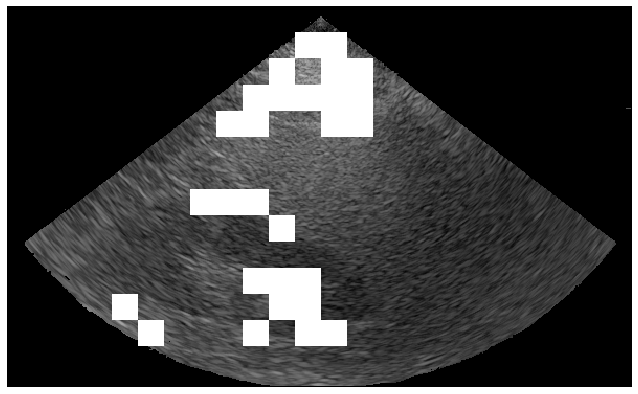

In [637]:
#IMAGES quick test for stdev segmentation
#tested on all images to define a unversal threshold
full_liver_std_thresh_1 = np.copy(m_test_img_9_h)

#define entropy threshold (for non-liver)
std_thresh = 19.5
std_liver_1 = []

for i in range(len(full_liver_windows)):
    [row_start, row_end, column_start, column_end] = full_liver_windows_2[i]
    mean, std = cv2.meanStdDev(full_liver_std_thresh_1[row_start:row_end,column_start:column_end])
    std_liver_1.append(int(std))

for i in range(len(full_liver_windows)):
    if std_liver_1[i] > std_thresh:
        [row_start, row_end, column_start, column_end] = full_liver_windows_2[i]
        full_liver_std_thresh_1[row_start:row_end,column_start:column_end] = 255

plt.figure(figsize=(12, 7))
plt.imshow(full_liver_std_thresh_1, cmap=plt.cm.gray)
plt.axis('off')

I tried the above cell on all 10 images, and found that the best universal threshold was 19.5. This gives similar results to the windows produced in entropy thresholding. I'll apply the same combo -> thresholding + std + closing, and compare the accuracy to that with entropy.

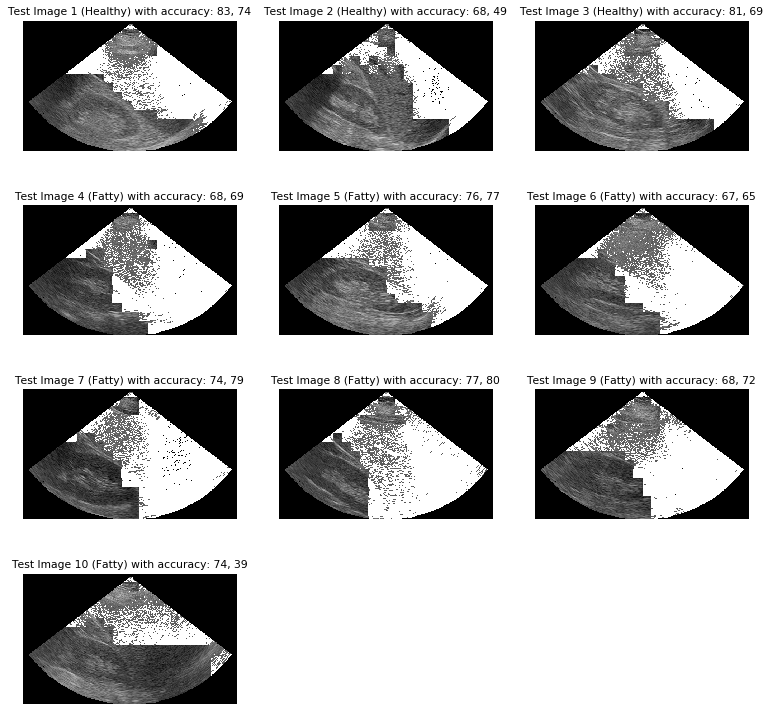

Mean Classification Accuracy is: 74.21747101505409 %
Mean Classification Accuracy for liver only is: 67.72460258163476 %


In [626]:
#show combo result of thresholding and standard deviation

#NOTE: this takes a while to run!
thresh_low = 10
thresh_high = 85
thresh_fatty_low = 10
thresh_fatty_high = 85

i1 = thresholding_2(m_test_img_1_h, thresh_low, thresh_high, 0)
i1 = std_thresh_combo(m_test_img_1_h, i1, full_liver_windows)
i2 = thresholding_2(m_test_img_2_h, thresh_low, thresh_high, 0)
i2 = std_thresh_combo(m_test_img_2_h, i2, full_liver_windows)
i3 = thresholding_2(m_test_img_3_h, thresh_low, thresh_high, 0)
i3 = std_thresh_combo(m_test_img_3_h, i3, full_liver_windows)
i4 = thresholding_2(m_test_img_4_h, thresh_fatty_low, thresh_fatty_high, 0)
i4 = std_thresh_combo(m_test_img_4_h, i4, full_liver_windows)
i5 = thresholding_2(m_test_img_5_h, thresh_fatty_low, thresh_fatty_high, 0)
i5 = std_thresh_combo(m_test_img_5_h, i5, full_liver_windows)
i6 = thresholding_2(m_test_img_6_h, thresh_fatty_low, thresh_fatty_high, 0)
i6 = std_thresh_combo(m_test_img_6_h, i6, full_liver_windows)
i7 = thresholding_2(m_test_img_7_h, thresh_fatty_low, thresh_fatty_high, 0)
i7 = std_thresh_combo(m_test_img_7_h, i7, full_liver_windows)
i8 = thresholding_2(m_test_img_8_h, thresh_fatty_low, thresh_fatty_high, 0)
i8 = std_thresh_combo(m_test_img_8_h, i8, full_liver_windows)
i9 = thresholding_2(m_test_img_9_h, thresh_fatty_low, thresh_fatty_high, 0)
i9 = std_thresh_combo(m_test_img_9_h, i9, full_liver_windows)
i10 = thresholding_2(m_test_img_10_h, thresh_fatty_low, thresh_fatty_high, 0)
i10 = std_thresh_combo(m_test_img_10_h, i10, full_liver_windows)

plot_10(i1, liver_mask_1, i2, liver_mask_2, i3, liver_mask_3, i4, liver_mask_4, i5, liver_mask_5, i6, liver_mask_6, i7, liver_mask_7, i8, liver_mask_8, i9, liver_mask_9, i10, liver_mask_10, mask)

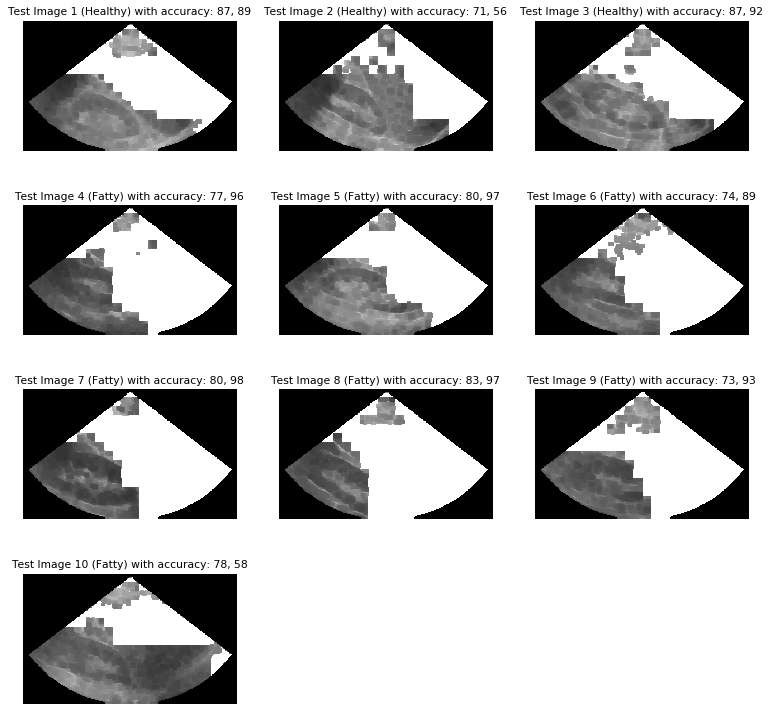

Mean Classification Accuracy is: 79.4348473502552 %
Mean Classification Accuracy for liver only is: 86.83044851333034 %


In [627]:
#apply the same closing techniques
i1 = cv2.morphologyEx(i1, cv2.MORPH_CLOSE, np.ones((11,11)))
i2 = cv2.morphologyEx(i2, cv2.MORPH_CLOSE, np.ones((11,11)))
i3 = cv2.morphologyEx(i3, cv2.MORPH_CLOSE, np.ones((11,11)))
i4 = cv2.morphologyEx(i4, cv2.MORPH_CLOSE, np.ones((11,11)))
i5 = cv2.morphologyEx(i5, cv2.MORPH_CLOSE, np.ones((11,11)))
i6 = cv2.morphologyEx(i6, cv2.MORPH_CLOSE, np.ones((11,11)))
i7 = cv2.morphologyEx(i7, cv2.MORPH_CLOSE, np.ones((11,11)))
i8 = cv2.morphologyEx(i8, cv2.MORPH_CLOSE, np.ones((11,11)))
i9 = cv2.morphologyEx(i9, cv2.MORPH_CLOSE, np.ones((11,11)))
i10 = cv2.morphologyEx(i10, cv2.MORPH_CLOSE, np.ones((11,11)))

plot_10(i1, liver_mask_1, i2, liver_mask_2, i3, liver_mask_3, i4, liver_mask_4, i5, liver_mask_5, i6, liver_mask_6, i7, liver_mask_7, i8, liver_mask_8, i9, liver_mask_9, i10, liver_mask_10, mask)

These results are even better than entropy thresholding after closing!

# Radiomic Features

Gray Level Difference Vector (GLDV)

In [ ]:
sgldm
fdta

Autocorrelation Feature in Horizontal Direction

Liver Autocorrelation Mean is: 1630.9206885243875
Non-Liver Autocorrelation Mean is: 1978.43220448583


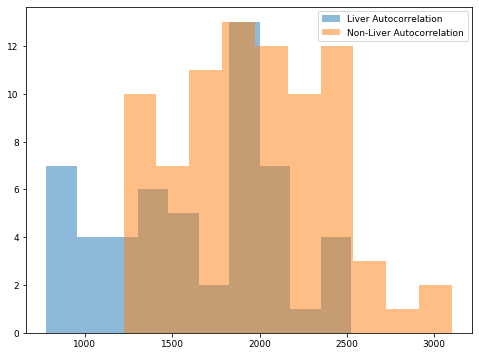

In [692]:
# plot histograms for image 1 to check if autocorrelation has any value
aut_liver = []
aut_nonliver = []

for i in range(len(liver_windows_6)):
    [row_start, row_end, column_start, column_end] = liver_windows_6[i]
    aut = autocoh(full_liver_1[row_start:row_end,column_start:column_end], 4)
    aut_liver.append(aut)

for i in range(len(nonliver_windows_6)):
    [row_start, row_end, column_start, column_end] = nonliver_windows_6[i]
    aut = autocoh(full_liver_6[row_start:row_end,column_start:column_end], 4)
    aut_nonliver.append(aut)
    
plt.figure(figsize=(8,6))
plt.hist(aut_liver, alpha=0.5, label='Liver Autocorrelation');
plt.hist(aut_nonliver, alpha=0.5, label='Non-Liver Autocorrelation');
plt.legend()
print('Liver Autocorrelation Mean is:', np.mean(aut_liver))
print('Non-Liver Autocorrelation Mean is:', np.mean(aut_nonliver))

It seems there is significant value (>2200), yet again, in classifying non-liver here. I'll test on a few images to find a good universal threshold.

(-0.5, 596.5, 363.5, -0.5)

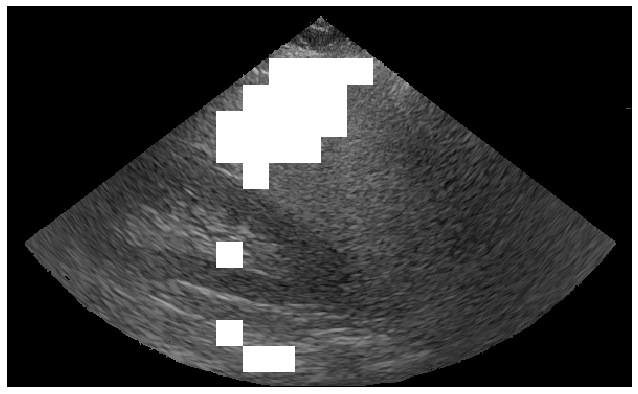

In [691]:
#IMAGES quick test for autocorrelation segmentation
#tested on all images to define a unversal threshold
img_x = np.copy(m_test_img_6_h)

#define entropy threshold (for non-liver)
aut_thresh = 2500
aut_liver = []

for i in range(len(full_liver_windows)):
    [row_start, row_end, column_start, column_end] = full_liver_windows[i]
    aut = autocoh(img_x[row_start:row_end,column_start:column_end], 4)
    aut_liver.append(aut)

for i in range(len(full_liver_windows)):
    if aut_liver[i] > aut_thresh:
        [row_start, row_end, column_start, column_end] = full_liver_windows[i]
        img_x[row_start:row_end,column_start:column_end] = 255

plt.figure(figsize=(12, 7))
plt.imshow(img_x, cmap=plt.cm.gray)
plt.axis('off')

I was unable to determine a good universal threshold for horizontal correlation. The horizontal correalation feature varies from image to image. In some images (ie. Image 1, Image 2, Image 3, Image 5, Image 10) a high horizontal autocorrelation value is a strong indication of non-liver tissue. This has to do twith the fact that liver texture is typically more granualr than surrounding tissues. However, for other images (ie. Image 4, Image 7, Image 8, Image 9), high horizontal autocorrelation values were a poor determinant of liver tissue. The horizontal elements were not as pronounced in these images. Different off-set values and threshold would need to be selected to correctly segment these images.

I will stop here, and consider the results from the combined STD and thresholding method to be the best for purposes of this project (79% and 87%). Several other texture feautures can be explored.

# Structuring Elements

In [152]:
# on image or mask, to detect large liver edge

In [ ]:
# write about in future steps